# Feature Engineering

---

1. Import packages
2. Load data
3. Feature engineering

---

## 1. Import packages

In [1348]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

In [1349]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

---
## 2. Load data

In [1350]:
df = pd.read_csv('./clean_data_after_eda.csv')
df["date_activ"] = pd.to_datetime(df["date_activ"], format='%Y-%m-%d')
df["date_end"] = pd.to_datetime(df["date_end"], format='%Y-%m-%d')
df["date_modif_prod"] = pd.to_datetime(df["date_modif_prod"], format='%Y-%m-%d')
df["date_renewal"] = pd.to_datetime(df["date_renewal"], format='%Y-%m-%d')

In [1351]:
df.head(3)

,Unnamed: 0,id,channel_sales,cons_12m,cons_gas_12m,cons_last_month,date_activ,date_end,date_modif_prod,date_renewal,...,mean_3m_price_p1_var,mean_3m_price_p2_var,mean_3m_price_p3_var,mean_3m_price_p1_fix,mean_3m_price_p2_fix,mean_3m_price_p3_fix,mean_3m_price_p1,mean_3m_price_p2,mean_3m_price_p3,churn
0,0,24011ae4ebbe3035111d65fa7c15bc57,foosdfpfkusacimwkcsosbicdxkicaua,0,54946,0,2013-06-15,2016-06-15,2015-11-01,2015-06-23,...,0.13176,0.09264,0.03691,42.49791,12.21867,8.14578,42.62966,12.31130,8.18269,1
1,1,d29c2c54acc38ff3c0614d0a653813dd,MISSING,4660,0,0,2009-08-21,2016-08-30,2009-08-21,2015-08-31,...,0.14760,0.00000,0.00000,44.44471,0.00000,0.00000,44.59231,0.00000,0.00000,0
2,2,764c75f661154dac3a6c254cd082ea7d,foosdfpfkusacimwkcsosbicdxkicaua,544,0,0,2010-04-16,2016-04-16,2010-04-16,2015-04-17,...,0.16780,0.08841,0.00000,44.44471,0.00000,0.00000,44.61251,0.08841,0.00000,0


---

## 3. Feature engineering

### Feature Creation
#### Difference between off-peak prices in December and preceding January

Below is the code created by your colleague to calculate the feature described above. Use this code to re-create this feature and then think about ways to build on this feature to create features with a higher predictive power.

In [1352]:
price_df = pd.read_csv('./price_data.csv')
price_df["price_date"] = pd.to_datetime(price_df["price_date"], format='%Y-%m-%d')
price_df.head()

,id,price_date,price_off_peak_var,price_peak_var,price_mid_peak_var,price_off_peak_fix,price_peak_fix,price_mid_peak_fix
0,038af19179925da21a25619c5a24b745,2015-01-01,0.15137,0.00000,0.00000,44.26693,0.00000,0.00000
1,038af19179925da21a25619c5a24b745,2015-02-01,0.15137,0.00000,0.00000,44.26693,0.00000,0.00000
2,038af19179925da21a25619c5a24b745,2015-03-01,0.15137,0.00000,0.00000,44.26693,0.00000,0.00000
3,038af19179925da21a25619c5a24b745,2015-04-01,0.14963,0.00000,0.00000,44.26693,0.00000,0.00000
4,038af19179925da21a25619c5a24b745,2015-05-01,0.14963,0.00000,0.00000,44.26693,0.00000,0.00000


In [1353]:
# Group off-peak prices by companies and month
monthly_price_by_id = price_df.groupby(['id', 'price_date']).agg({'price_off_peak_var': 'mean', 'price_off_peak_fix': 'mean'}).reset_index()

# Get january and december prices
jan_prices = monthly_price_by_id.groupby('id').first().reset_index()
dec_prices = monthly_price_by_id.groupby('id').last().reset_index()

# Calculate the difference
diff_1 = pd.merge(dec_prices.rename(columns={'price_off_peak_var': 'dec_1', 'price_off_peak_fix': 'dec_2'}), jan_prices.drop(columns='price_date'), on='id')
diff_1['offpeak_diff_dec_january_energy'] = diff_1['dec_1'] - diff_1['price_off_peak_var']
diff_1['offpeak_diff_dec_january_power'] = diff_1['dec_2'] - diff_1['price_off_peak_fix']
diff_1 = diff_1[['id', 'offpeak_diff_dec_january_energy','offpeak_diff_dec_january_power']]
diff_1.head()

,id,offpeak_diff_dec_january_energy,offpeak_diff_dec_january_power
0,0002203ffbb812588b632b9e628cc38d,-0.00619,0.16292
1,0004351ebdd665e6ee664792efc4fd13,-0.00410,0.17778
2,0010bcc39e42b3c2131ed2ce55246e3c,0.05044,1.50000
3,0010ee3855fdea87602a5b7aba8e42de,-0.01002,0.16292
4,00114d74e963e47177db89bc70108537,-0.00399,-0.00000


#### Difference between peak prices in December and preceding January

In [1354]:
# Group peak prices by companies and month
monthly_price_by_id = price_df.groupby(['id', 'price_date']).agg({'price_peak_var': 'mean', 'price_peak_fix': 'mean'}).reset_index()

# Get january and december prices
jan_prices = monthly_price_by_id.groupby('id').first().reset_index()
dec_prices = monthly_price_by_id.groupby('id').last().reset_index()

# Calculate the difference
diff_2 = pd.merge(dec_prices.rename(columns={'price_peak_var': 'dec_1', 'price_peak_fix': 'dec_2'}), jan_prices.drop(columns='price_date'), on='id')
diff_2['peak_diff_dec_january_energy'] = diff_2['dec_1'] - diff_2['price_peak_var']
diff_2['peak_diff_dec_january_power'] = diff_2['dec_2'] - diff_2['price_peak_fix']
diff_2 = diff_2[['id', 'peak_diff_dec_january_energy','peak_diff_dec_january_power']]
diff_2.head()

,id,peak_diff_dec_january_energy,peak_diff_dec_january_power
0,0002203ffbb812588b632b9e628cc38d,-0.00230,0.09775
1,0004351ebdd665e6ee664792efc4fd13,0.00000,0.00000
2,0010bcc39e42b3c2131ed2ce55246e3c,0.00000,0.00000
3,0010ee3855fdea87602a5b7aba8e42de,-0.00512,0.09775
4,00114d74e963e47177db89bc70108537,0.00000,0.00000


#### Difference between mid-peak prices in December and preceding January

In [1355]:
# Group mid peak prices by companies and month
monthly_price_by_id = price_df.groupby(['id', 'price_date']).agg({'price_mid_peak_var': 'mean', 'price_mid_peak_fix': 'mean'}).reset_index()

# Get january and december prices
jan_prices = monthly_price_by_id.groupby('id').first().reset_index()
dec_prices = monthly_price_by_id.groupby('id').last().reset_index()

# Calculate the difference
diff_3 = pd.merge(dec_prices.rename(columns={'price_mid_peak_var': 'dec_1', 'price_mid_peak_fix': 'dec_2'}), jan_prices.drop(columns='price_date'), on='id')
diff_3['midpeak_diff_dec_january_energy'] = diff_3['dec_1'] - diff_3['price_mid_peak_var']
diff_3['midpeak_diff_dec_january_power'] = diff_3['dec_2'] - diff_3['price_mid_peak_fix']
diff_3 = diff_3[['id', 'midpeak_diff_dec_january_energy','midpeak_diff_dec_january_power']]
diff_3.head()

,id,midpeak_diff_dec_january_energy,midpeak_diff_dec_january_power
0,0002203ffbb812588b632b9e628cc38d,0.00349,0.06517
1,0004351ebdd665e6ee664792efc4fd13,0.00000,0.00000
2,0010bcc39e42b3c2131ed2ce55246e3c,0.00000,0.00000
3,0010ee3855fdea87602a5b7aba8e42de,0.00076,0.06517
4,00114d74e963e47177db89bc70108537,0.00000,0.00000


In [1356]:
df_analysis = diff_1.merge(diff_2, on='id').merge(diff_3, on='id')
df_analysis

,id,offpeak_diff_dec_january_energy,offpeak_diff_dec_january_power,peak_diff_dec_january_energy,peak_diff_dec_january_power,midpeak_diff_dec_january_energy,midpeak_diff_dec_january_power
0,0002203ffbb812588b632b9e628cc38d,-0.00619,0.16292,-0.00230,0.09775,0.00349,0.06517
1,0004351ebdd665e6ee664792efc4fd13,-0.00410,0.17778,0.00000,0.00000,0.00000,0.00000
2,0010bcc39e42b3c2131ed2ce55246e3c,0.05044,1.50000,0.00000,0.00000,0.00000,0.00000
3,0010ee3855fdea87602a5b7aba8e42de,-0.01002,0.16292,-0.00512,0.09775,0.00076,0.06517
4,00114d74e963e47177db89bc70108537,-0.00399,-0.00000,0.00000,0.00000,0.00000,0.00000
...,...,...,...,...,...,...,...
16091,ffef185810e44254c3a4c6395e6b4d8a,-0.05023,-0.33508,-0.03879,-0.40025,-0.02273,-0.43283
16092,fffac626da707b1b5ab11e8431a4d0a2,-0.00378,0.17778,0.00000,0.00000,0.00000,0.00000
16093,fffc0cacd305dd51f316424bbb08d1bd,-0.00176,0.16492,-0.00371,0.09975,-0.00733,0.06717
16094,fffe4f5646aa39c7f97f95ae2679ce64,-0.00939,0.16292,-0.00494,0.09775,0.00103,0.06517


#### Average price difference across periods  

In [1357]:
# Aggregate average prices per period by company
mean_prices = price_df.groupby(['id']).agg({
    'price_off_peak_var': 'mean', 
    'price_peak_var': 'mean', 
    'price_mid_peak_var': 'mean',
    'price_off_peak_fix': 'mean',
    'price_peak_fix': 'mean',
    'price_mid_peak_fix': 'mean'    
}).reset_index()

In [1358]:
# Calculate the mean difference between consecutive periods
mean_prices['off_peak_peak_var_mean_diff'] = mean_prices['price_off_peak_var'] - mean_prices['price_peak_var']
mean_prices['peak_mid_peak_var_mean_diff'] = mean_prices['price_peak_var'] - mean_prices['price_mid_peak_var']
mean_prices['off_peak_mid_peak_var_mean_diff'] = mean_prices['price_off_peak_var'] - mean_prices['price_mid_peak_var']
mean_prices['off_peak_peak_fix_mean_diff'] = mean_prices['price_off_peak_fix'] - mean_prices['price_peak_fix']
mean_prices['peak_mid_peak_fix_mean_diff'] = mean_prices['price_peak_fix'] - mean_prices['price_mid_peak_fix']
mean_prices['off_peak_mid_peak_fix_mean_diff'] = mean_prices['price_off_peak_fix'] - mean_prices['price_mid_peak_fix']

In [1359]:
columns = [
    'id', 
    'off_peak_peak_var_mean_diff',
    'peak_mid_peak_var_mean_diff', 
    'off_peak_mid_peak_var_mean_diff',
    'off_peak_peak_fix_mean_diff', 
    'peak_mid_peak_fix_mean_diff', 
    'off_peak_mid_peak_fix_mean_diff'
]
df_analysis = pd.merge(df_analysis, mean_prices[columns], on='id')


In [1360]:
df_analysis

,id,offpeak_diff_dec_january_energy,offpeak_diff_dec_january_power,peak_diff_dec_january_energy,peak_diff_dec_january_power,midpeak_diff_dec_january_energy,midpeak_diff_dec_january_power,off_peak_peak_var_mean_diff,peak_mid_peak_var_mean_diff,off_peak_mid_peak_var_mean_diff,off_peak_peak_fix_mean_diff,peak_mid_peak_fix_mean_diff,off_peak_mid_peak_fix_mean_diff
0,0002203ffbb812588b632b9e628cc38d,-0.00619,0.16292,-0.00230,0.09775,0.00349,0.06517,0.02054,0.03063,0.05118,16.28069,8.14034,24.42104
1,0004351ebdd665e6ee664792efc4fd13,-0.00410,0.17778,0.00000,0.00000,0.00000,0.00000,0.14643,0.00000,0.14643,44.38545,0.00000,44.38545
2,0010bcc39e42b3c2131ed2ce55246e3c,0.05044,1.50000,0.00000,0.00000,0.00000,0.00000,0.18156,0.00000,0.18156,45.31971,0.00000,45.31971
3,0010ee3855fdea87602a5b7aba8e42de,-0.01002,0.16292,-0.00512,0.09775,0.00076,0.06517,0.02046,0.02926,0.04973,16.25897,8.12948,24.38846
4,00114d74e963e47177db89bc70108537,-0.00399,-0.00000,0.00000,0.00000,0.00000,0.00000,0.14793,0.00000,0.14793,44.26693,0.00000,44.26693
...,...,...,...,...,...,...,...,...,...,...,...,...,...
16091,ffef185810e44254c3a4c6395e6b4d8a,-0.05023,-0.33508,-0.03879,-0.40025,-0.02273,-0.43283,0.02374,0.03434,0.05808,16.25897,8.12948,24.38846
16092,fffac626da707b1b5ab11e8431a4d0a2,-0.00378,0.17778,0.00000,0.00000,0.00000,0.00000,0.14714,0.00000,0.14714,44.31138,0.00000,44.31138
16093,fffc0cacd305dd51f316424bbb08d1bd,-0.00176,0.16492,-0.00371,0.09975,-0.00733,0.06717,0.02438,0.03465,0.05904,16.26440,8.13220,24.39660
16094,fffe4f5646aa39c7f97f95ae2679ce64,-0.00939,0.16292,-0.00494,0.09775,0.00103,0.06517,0.02036,0.02976,0.05012,16.24268,8.12134,24.36402


#### Maximun price difference across periods and months

In [1361]:
# Aggregate average prices per period by company
mean_prices_by_month = price_df.groupby(['id', 'price_date']).agg({
    'price_off_peak_var': 'mean', 
    'price_peak_var': 'mean', 
    'price_mid_peak_var': 'mean',
    'price_off_peak_fix': 'mean',
    'price_peak_fix': 'mean',
    'price_mid_peak_fix': 'mean'    
}).reset_index()

In [1362]:
# Calculate the mean difference between consecutive periods
mean_prices_by_month['off_peak_peak_var_mean_diff'] = mean_prices_by_month['price_off_peak_var'] - mean_prices_by_month['price_peak_var']
mean_prices_by_month['peak_mid_peak_var_mean_diff'] = mean_prices_by_month['price_peak_var'] - mean_prices_by_month['price_mid_peak_var']
mean_prices_by_month['off_peak_mid_peak_var_mean_diff'] = mean_prices_by_month['price_off_peak_var'] - mean_prices_by_month['price_mid_peak_var']
mean_prices_by_month['off_peak_peak_fix_mean_diff'] = mean_prices_by_month['price_off_peak_fix'] - mean_prices_by_month['price_peak_fix']
mean_prices_by_month['peak_mid_peak_fix_mean_diff'] = mean_prices_by_month['price_peak_fix'] - mean_prices_by_month['price_mid_peak_fix']
mean_prices_by_month['off_peak_mid_peak_fix_mean_diff'] = mean_prices_by_month['price_off_peak_fix'] - mean_prices_by_month['price_mid_peak_fix']

In [1363]:
# Calculate the maximum monthly difference across time periods
max_diff_across_periods_months = mean_prices_by_month.groupby(['id']).agg({
    'off_peak_peak_var_mean_diff': 'max',
    'peak_mid_peak_var_mean_diff': 'max',
    'off_peak_mid_peak_var_mean_diff': 'max',
    'off_peak_peak_fix_mean_diff': 'max',
    'peak_mid_peak_fix_mean_diff': 'max',
    'off_peak_mid_peak_fix_mean_diff': 'max'
}).reset_index().rename(
    columns={
        'off_peak_peak_var_mean_diff': 'off_peak_peak_var_max_monthly_diff',
        'peak_mid_peak_var_mean_diff': 'peak_mid_peak_var_max_monthly_diff',
        'off_peak_mid_peak_var_mean_diff': 'off_peak_mid_peak_var_max_monthly_diff',
        'off_peak_peak_fix_mean_diff': 'off_peak_peak_fix_max_monthly_diff',
        'peak_mid_peak_fix_mean_diff': 'peak_mid_peak_fix_max_monthly_diff',
        'off_peak_mid_peak_fix_mean_diff': 'off_peak_mid_peak_fix_max_monthly_diff'
    }
)

In [1364]:
columns = [
    'id',
    'off_peak_peak_var_max_monthly_diff',
    'peak_mid_peak_var_max_monthly_diff',
    'off_peak_mid_peak_var_max_monthly_diff',
    'off_peak_peak_fix_max_monthly_diff',
    'peak_mid_peak_fix_max_monthly_diff',
    'off_peak_mid_peak_fix_max_monthly_diff'
]

df_analysis = pd.merge(df_analysis, max_diff_across_periods_months[columns], on='id')
df_analysis.head()

,id,offpeak_diff_dec_january_energy,offpeak_diff_dec_january_power,peak_diff_dec_january_energy,peak_diff_dec_january_power,midpeak_diff_dec_january_energy,midpeak_diff_dec_january_power,off_peak_peak_var_mean_diff,peak_mid_peak_var_mean_diff,off_peak_mid_peak_var_mean_diff,off_peak_peak_fix_mean_diff,peak_mid_peak_fix_mean_diff,off_peak_mid_peak_fix_mean_diff,off_peak_peak_var_max_monthly_diff,peak_mid_peak_var_max_monthly_diff,off_peak_mid_peak_var_max_monthly_diff,off_peak_peak_fix_max_monthly_diff,peak_mid_peak_fix_max_monthly_diff,off_peak_mid_peak_fix_max_monthly_diff
0,0002203ffbb812588b632b9e628cc38d,-0.00619,0.16292,-0.00230,0.09775,0.00349,0.06517,0.02054,0.03063,0.05118,16.28069,8.14034,24.42104,0.02222,0.03374,0.05587,16.29155,8.14578,24.43733
1,0004351ebdd665e6ee664792efc4fd13,-0.00410,0.17778,0.00000,0.00000,0.00000,0.00000,0.14643,0.00000,0.14643,44.38545,0.00000,44.38545,0.14841,0.00000,0.14841,44.44471,0.00000,44.44471
2,0010bcc39e42b3c2131ed2ce55246e3c,0.05044,1.50000,0.00000,0.00000,0.00000,0.00000,0.18156,0.00000,0.18156,45.31971,0.00000,45.31971,0.20574,0.00000,0.20574,45.94471,0.00000,45.94471
3,0010ee3855fdea87602a5b7aba8e42de,-0.01002,0.16292,-0.00512,0.09775,0.00076,0.06517,0.02046,0.02926,0.04973,16.25897,8.12948,24.38846,0.02258,0.03186,0.05444,16.29155,8.14578,24.43733
4,00114d74e963e47177db89bc70108537,-0.00399,-0.00000,0.00000,0.00000,0.00000,0.00000,0.14793,0.00000,0.14793,44.26693,0.00000,44.26693,0.14990,0.00000,0.14990,44.26693,0.00000,44.26693


#### Forcasted 12 month consumption difference (past 12 m)

In [1365]:
con_diff_12m_forcast = df['cons_12m'] -df['forecast_cons_12m'] 
con_diff_12m_forcast = pd.DataFrame(con_diff_12m_forcast, columns=['con_diff_12m_forcast'])
con_diff_12m_forcast['id'] = df['id']
con_diff_12m_forcast = con_diff_12m_forcast.astype({'id': str})


df_analysis = df_analysis.join(con_diff_12m_forcast.set_index('id'), on='id')
df_analysis

,id,offpeak_diff_dec_january_energy,offpeak_diff_dec_january_power,peak_diff_dec_january_energy,peak_diff_dec_january_power,midpeak_diff_dec_january_energy,midpeak_diff_dec_january_power,off_peak_peak_var_mean_diff,peak_mid_peak_var_mean_diff,off_peak_mid_peak_var_mean_diff,off_peak_peak_fix_mean_diff,peak_mid_peak_fix_mean_diff,off_peak_mid_peak_fix_mean_diff,off_peak_peak_var_max_monthly_diff,peak_mid_peak_var_max_monthly_diff,off_peak_mid_peak_var_max_monthly_diff,off_peak_peak_fix_max_monthly_diff,peak_mid_peak_fix_max_monthly_diff,off_peak_mid_peak_fix_max_monthly_diff,con_diff_12m_forcast
0,0002203ffbb812588b632b9e628cc38d,-0.00619,0.16292,-0.00230,0.09775,0.00349,0.06517,0.02054,0.03063,0.05118,16.28069,8.14034,24.42104,0.02222,0.03374,0.05587,16.29155,8.14578,24.43733,21304.94000
1,0004351ebdd665e6ee664792efc4fd13,-0.00410,0.17778,0.00000,0.00000,0.00000,0.00000,0.14643,0.00000,0.14643,44.38545,0.00000,44.38545,0.14841,0.00000,0.14841,44.44471,0.00000,44.44471,3462.23000
2,0010bcc39e42b3c2131ed2ce55246e3c,0.05044,1.50000,0.00000,0.00000,0.00000,0.00000,0.18156,0.00000,0.18156,45.31971,0.00000,45.31971,0.20574,0.00000,0.20574,45.94471,0.00000,45.94471,6128.84000
3,0010ee3855fdea87602a5b7aba8e42de,-0.01002,0.16292,-0.00512,0.09775,0.00076,0.06517,0.02046,0.02926,0.04973,16.25897,8.12948,24.38846,0.02258,0.03186,0.05444,16.29155,8.14578,24.43733,NaN
4,00114d74e963e47177db89bc70108537,-0.00399,-0.00000,0.00000,0.00000,0.00000,0.00000,0.14793,0.00000,0.14793,44.26693,0.00000,44.26693,0.14990,0.00000,0.14990,44.26693,0.00000,44.26693,9600.59000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16091,ffef185810e44254c3a4c6395e6b4d8a,-0.05023,-0.33508,-0.03879,-0.40025,-0.02273,-0.43283,0.02374,0.03434,0.05808,16.25897,8.12948,24.38846,0.02913,0.04203,0.07116,16.29155,8.14578,24.43733,NaN
16092,fffac626da707b1b5ab11e8431a4d0a2,-0.00378,0.17778,0.00000,0.00000,0.00000,0.00000,0.14714,0.00000,0.14714,44.31138,0.00000,44.31138,0.14883,0.00000,0.14883,44.44471,0.00000,44.44471,129098.59000
16093,fffc0cacd305dd51f316424bbb08d1bd,-0.00176,0.16492,-0.00371,0.09975,-0.00733,0.06717,0.02438,0.03465,0.05904,16.26440,8.13220,24.39660,0.02852,0.03959,0.06811,16.29155,8.14578,24.43733,36843.44000
16094,fffe4f5646aa39c7f97f95ae2679ce64,-0.00939,0.16292,-0.00494,0.09775,0.00103,0.06517,0.02036,0.02976,0.05012,16.24268,8.12134,24.36402,0.02214,0.03194,0.05408,16.29155,8.14578,24.43733,28752.87000


#### Company Tenue

In [1366]:
df['tenure'] = ((df['date_end'] - df['date_activ'])/ np.timedelta64(1, 'Y')).astype(int)

In [1367]:
df.groupby(['tenure']).agg({'churn': 'mean'}).sort_values(by='churn', ascending=False)

,churn
tenure,
3,0.14384
2,0.13308
4,0.12576
13,0.09524
5,0.08543
12,0.08333
6,0.08071
7,0.07339
11,0.06358


In [1368]:
def convert_months(reference_date, df, column):
    """
    Input a column with timedeltas and return months
    """
    time_delta = reference_date - df[column]
    months = (time_delta / np.timedelta64(1, 'M')).astype(int)
    return months

In [1369]:
# Create reference date
reference_date = datetime(2016, 1, 1)

# Create columns
df['months_activ'] = convert_months(reference_date, df, 'date_activ')
df['months_to_end'] = -convert_months(reference_date, df, 'date_end')
df['months_modif_prod'] = convert_months(reference_date, df, 'date_modif_prod')
df['months_renewal'] = convert_months(reference_date, df, 'date_renewal')

In [1370]:
df_analysis = df_analysis.join(df[['id', 'months_activ','months_to_end', 'months_modif_prod', 'months_renewal' ]].set_index('id'), on='id')
df_analysis

,id,offpeak_diff_dec_january_energy,offpeak_diff_dec_january_power,peak_diff_dec_january_energy,peak_diff_dec_january_power,midpeak_diff_dec_january_energy,midpeak_diff_dec_january_power,off_peak_peak_var_mean_diff,peak_mid_peak_var_mean_diff,off_peak_mid_peak_var_mean_diff,...,peak_mid_peak_var_max_monthly_diff,off_peak_mid_peak_var_max_monthly_diff,off_peak_peak_fix_max_monthly_diff,peak_mid_peak_fix_max_monthly_diff,off_peak_mid_peak_fix_max_monthly_diff,con_diff_12m_forcast,months_activ,months_to_end,months_modif_prod,months_renewal
0,0002203ffbb812588b632b9e628cc38d,-0.00619,0.16292,-0.00230,0.09775,0.00349,0.06517,0.02054,0.03063,0.05118,...,0.03374,0.05587,16.29155,8.14578,24.43733,21304.94000,71.00000,1.00000,71.00000,10.00000
1,0004351ebdd665e6ee664792efc4fd13,-0.00410,0.17778,0.00000,0.00000,0.00000,0.00000,0.14643,0.00000,0.14643,...,0.00000,0.14841,44.44471,0.00000,44.44471,3462.23000,76.00000,5.00000,30.00000,6.00000
2,0010bcc39e42b3c2131ed2ce55246e3c,0.05044,1.50000,0.00000,0.00000,0.00000,0.00000,0.18156,0.00000,0.18156,...,0.00000,0.20574,45.94471,0.00000,45.94471,6128.84000,34.00000,4.00000,7.00000,10.00000
3,0010ee3855fdea87602a5b7aba8e42de,-0.01002,0.16292,-0.00512,0.09775,0.00076,0.06517,0.02046,0.02926,0.04973,...,0.03186,0.05444,16.29155,8.14578,24.43733,NaN,NaN,NaN,NaN,NaN
4,00114d74e963e47177db89bc70108537,-0.00399,-0.00000,0.00000,0.00000,0.00000,0.00000,0.14793,0.00000,0.14793,...,0.00000,0.14990,44.26693,0.00000,44.26693,9600.59000,70.00000,2.00000,70.00000,9.00000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16091,ffef185810e44254c3a4c6395e6b4d8a,-0.05023,-0.33508,-0.03879,-0.40025,-0.02273,-0.43283,0.02374,0.03434,0.05808,...,0.04203,0.07116,16.29155,8.14578,24.43733,NaN,NaN,NaN,NaN,NaN
16092,fffac626da707b1b5ab11e8431a4d0a2,-0.00378,0.17778,0.00000,0.00000,0.00000,0.00000,0.14714,0.00000,0.14714,...,0.00000,0.14883,44.44471,0.00000,44.44471,129098.59000,63.00000,8.00000,63.00000,3.00000
16093,fffc0cacd305dd51f316424bbb08d1bd,-0.00176,0.16492,-0.00371,0.09975,-0.00733,0.06717,0.02438,0.03465,0.05904,...,0.03959,0.06811,16.29155,8.14578,24.43733,36843.44000,30.00000,5.00000,18.00000,5.00000
16094,fffe4f5646aa39c7f97f95ae2679ce64,-0.00939,0.16292,-0.00494,0.09775,0.00103,0.06517,0.02036,0.02976,0.05012,...,0.03194,0.05408,16.29155,8.14578,24.43733,28752.87000,51.00000,8.00000,51.00000,3.00000


In [1371]:
df_analysis.isnull().sum()

id                                           0
offpeak_diff_dec_january_energy              0
offpeak_diff_dec_january_power               0
peak_diff_dec_january_energy                 0
peak_diff_dec_january_power                  0
midpeak_diff_dec_january_energy              0
midpeak_diff_dec_january_power               0
off_peak_peak_var_mean_diff                  0
peak_mid_peak_var_mean_diff                  0
off_peak_mid_peak_var_mean_diff              0
off_peak_peak_fix_mean_diff                  0
peak_mid_peak_fix_mean_diff                  0
off_peak_mid_peak_fix_mean_diff              0
off_peak_peak_var_max_monthly_diff           0
peak_mid_peak_var_max_monthly_diff           0
off_peak_mid_peak_var_max_monthly_diff       0
off_peak_peak_fix_max_monthly_diff           0
peak_mid_peak_fix_max_monthly_diff           0
off_peak_mid_peak_fix_max_monthly_diff       0
con_diff_12m_forcast                      1491
months_activ                              1491
months_to_end

### Feature Preprocessing

#### Missing Values

In [1372]:
df_trial= df_analysis.astype({'id': str}).join(df.astype({'id': str})[['id', 'channel_sales', 'cons_12m', 'cons_gas_12m', 'cons_last_month',
            'forecast_cons_12m', 'forecast_cons_year', 'forecast_discount_energy',
       'forecast_meter_rent_12m', 'forecast_price_energy_p1',
       'forecast_price_energy_p2', 'forecast_price_pow_p1', 'has_gas',
       'imp_cons', 'margin_gross_pow_ele', 'margin_net_pow_ele', 'nb_prod_act',
       'net_margin', 'num_years_antig', 'origin_up', 'pow_max', 'churn']].set_index('id'), on= 'id')
df_trial

,id,offpeak_diff_dec_january_energy,offpeak_diff_dec_january_power,peak_diff_dec_january_energy,peak_diff_dec_january_power,midpeak_diff_dec_january_energy,midpeak_diff_dec_january_power,off_peak_peak_var_mean_diff,peak_mid_peak_var_mean_diff,off_peak_mid_peak_var_mean_diff,...,has_gas,imp_cons,margin_gross_pow_ele,margin_net_pow_ele,nb_prod_act,net_margin,num_years_antig,origin_up,pow_max,churn
0,0002203ffbb812588b632b9e628cc38d,-0.00619,0.16292,-0.00230,0.09775,0.00349,0.06517,0.02054,0.03063,0.05118,...,f,40.78000,43.08000,43.08000,1.00000,81.42000,6.00000,kamkkxfxxuwbdslkwifmmcsiusiuosws,17.25000,0.00000
1,0004351ebdd665e6ee664792efc4fd13,-0.00410,0.17778,0.00000,0.00000,0.00000,0.00000,0.14643,0.00000,0.14643,...,f,0.00000,24.42000,24.42000,1.00000,61.58000,6.00000,kamkkxfxxuwbdslkwifmmcsiusiuosws,13.20000,0.00000
2,0010bcc39e42b3c2131ed2ce55246e3c,0.05044,1.50000,0.00000,0.00000,0.00000,0.00000,0.18156,0.00000,0.18156,...,f,213.76000,38.58000,38.58000,2.00000,81.61000,3.00000,lxidpiddsbxsbosboudacockeimpuepw,13.85600,0.00000
3,0010ee3855fdea87602a5b7aba8e42de,-0.01002,0.16292,-0.00512,0.09775,0.00076,0.06517,0.02046,0.02926,0.04973,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,00114d74e963e47177db89bc70108537,-0.00399,-0.00000,0.00000,0.00000,0.00000,0.00000,0.14793,0.00000,0.14793,...,f,0.00000,29.76000,29.76000,1.00000,157.99000,6.00000,kamkkxfxxuwbdslkwifmmcsiusiuosws,13.20000,0.00000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16091,ffef185810e44254c3a4c6395e6b4d8a,-0.05023,-0.33508,-0.03879,-0.40025,-0.02273,-0.43283,0.02374,0.03434,0.05808,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
16092,fffac626da707b1b5ab11e8431a4d0a2,-0.00378,0.17778,0.00000,0.00000,0.00000,0.00000,0.14714,0.00000,0.14714,...,f,0.00000,12.98000,12.98000,1.00000,191.60000,5.00000,lxidpiddsbxsbosboudacockeimpuepw,15.00000,0.00000
16093,fffc0cacd305dd51f316424bbb08d1bd,-0.00176,0.16492,-0.00371,0.09975,-0.00733,0.06717,0.02438,0.03465,0.05904,...,t,599.08000,45.36000,45.36000,2.00000,351.39000,3.00000,lxidpiddsbxsbosboudacockeimpuepw,16.50000,0.00000
16094,fffe4f5646aa39c7f97f95ae2679ce64,-0.00939,0.16292,-0.00494,0.09775,0.00103,0.06517,0.02036,0.02976,0.05012,...,t,487.59000,19.68000,19.68000,3.00000,361.40000,4.00000,lxidpiddsbxsbosboudacockeimpuepw,31.50000,0.00000


In [1373]:
print('Columns Missing Values Percentage: ',
"""

""", 
df_trial.isnull().sum()/ df_trial.shape[0] *100)


Columns Missing Values Percentage:  

 id                                       0.00000
offpeak_diff_dec_january_energy          0.00000
offpeak_diff_dec_january_power           0.00000
peak_diff_dec_january_energy             0.00000
peak_diff_dec_january_power              0.00000
midpeak_diff_dec_january_energy          0.00000
midpeak_diff_dec_january_power           0.00000
off_peak_peak_var_mean_diff              0.00000
peak_mid_peak_var_mean_diff              0.00000
off_peak_mid_peak_var_mean_diff          0.00000
off_peak_peak_fix_mean_diff              0.00000
peak_mid_peak_fix_mean_diff              0.00000
off_peak_mid_peak_fix_mean_diff          0.00000
off_peak_peak_var_max_monthly_diff       0.00000
peak_mid_peak_var_max_monthly_diff       0.00000
off_peak_mid_peak_var_max_monthly_diff   0.00000
off_peak_peak_fix_max_monthly_diff       0.00000
peak_mid_peak_fix_max_monthly_diff       0.00000
off_peak_mid_peak_fix_max_monthly_diff   0.00000
con_diff_12m_forcast          

In [1374]:
#ivestigate missing values
df_trial.isnull().sum()/ df_trial.shape[0] *100
df_trial.dropna(inplace= True)
df_analysis= df_trial.copy()
df_analysis.columns

Index(['id', 'offpeak_diff_dec_january_energy',
       'offpeak_diff_dec_january_power', 'peak_diff_dec_january_energy',
       'peak_diff_dec_january_power', 'midpeak_diff_dec_january_energy',
       'midpeak_diff_dec_january_power', 'off_peak_peak_var_mean_diff',
       'peak_mid_peak_var_mean_diff', 'off_peak_mid_peak_var_mean_diff',
       'off_peak_peak_fix_mean_diff', 'peak_mid_peak_fix_mean_diff',
       'off_peak_mid_peak_fix_mean_diff', 'off_peak_peak_var_max_monthly_diff',
       'peak_mid_peak_var_max_monthly_diff',
       'off_peak_mid_peak_var_max_monthly_diff',
       'off_peak_peak_fix_max_monthly_diff',
       'peak_mid_peak_fix_max_monthly_diff',
       'off_peak_mid_peak_fix_max_monthly_diff', 'con_diff_12m_forcast',
       'months_activ', 'months_to_end', 'months_modif_prod', 'months_renewal',
       'channel_sales', 'cons_12m', 'cons_gas_12m', 'cons_last_month',
       'forecast_cons_12m', 'forecast_cons_year', 'forecast_discount_energy',
       'forecast_meter_rent

#### Outliers

In [1375]:
numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']

newdf = df_analysis.select_dtypes(include=numerics)

In [1376]:
col_num= ['id', 'offpeak_diff_dec_january_energy',
       'offpeak_diff_dec_january_power', 'peak_diff_dec_january_energy',
       'peak_diff_dec_january_power', 'midpeak_diff_dec_january_energy',
       'midpeak_diff_dec_january_power', 'renewal', 'modif',
       'con_diff_12m_forcast', 'cons_12m', 'con_diff_12m_forcast','cons_gas_12m',
       'cons_last_month', 'forecast_cons_12m', 'forecast_cons_year',
       'forecast_discount_energy', 'forecast_meter_rent_12m',
       'forecast_price_energy_p1', 'forecast_price_energy_p2',
       'forecast_price_pow_p1','imp_cons', 'margin_gross_pow_ele',
       'margin_net_pow_ele', 'nb_prod_act', 'net_margin', 'num_years_antig',
       'pow_max']
df_ana_num= pd.concat([df_analysis['id'],newdf], axis= 1)

In [1377]:
# Define a function to replace outliers as NaN using Z-score method
def replace_outliers_with_nan(df, threshold=3):
    # Calculate Z-score for each column in the dataframe
    z_scores = df.apply(lambda x: np.abs((x - x.mean()) / x.std()))
    # Replace values outside of threshold with NaN
    df[z_scores > threshold] = np.nan
    return df

# Replace outliers as NaN in dataframe df_ana_num
df_ana_num_outliers = replace_outliers_with_nan(df_ana_num.iloc[:, 1:])

df_ana_num_outliers['id']= df_ana_num['id']
# drop missing values after outliers being removed
df_ana_num_outliers.dropna(inplace= True)
df_ana_num= df_ana_num_outliers.copy()

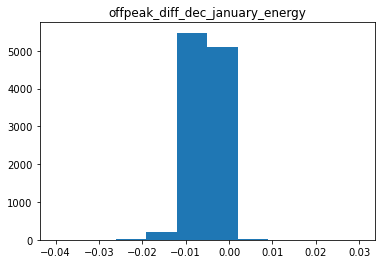

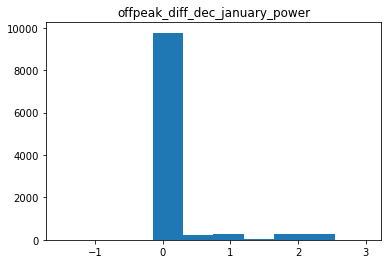

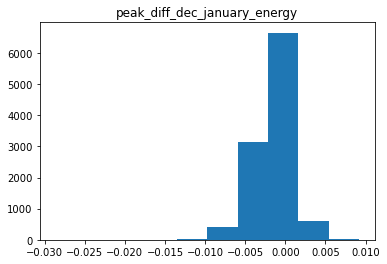

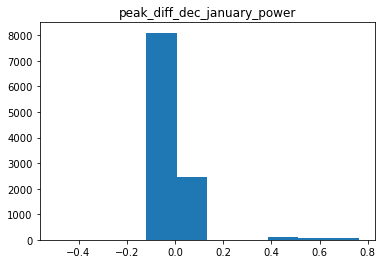

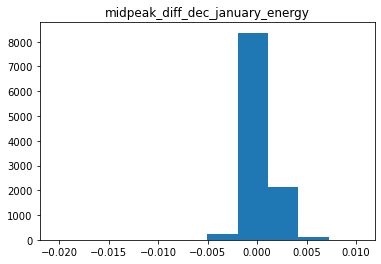

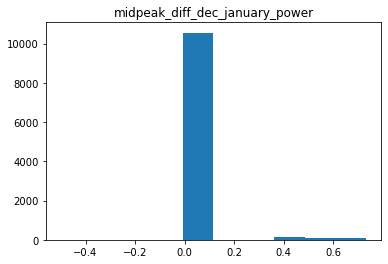

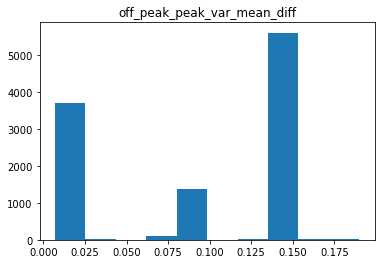

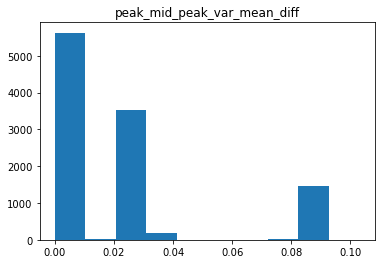

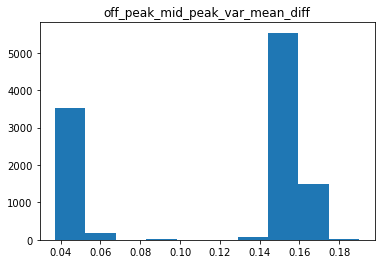

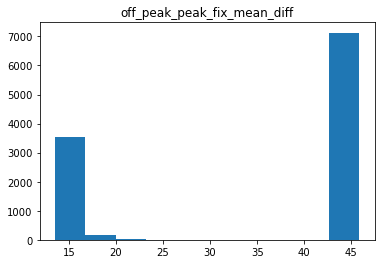

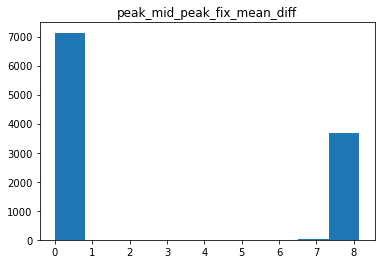

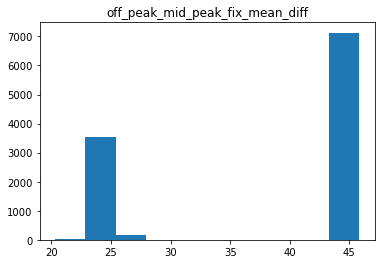

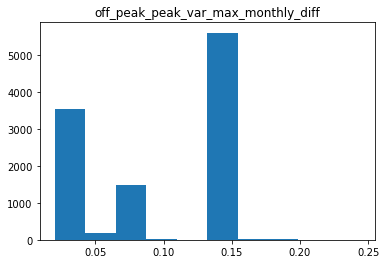

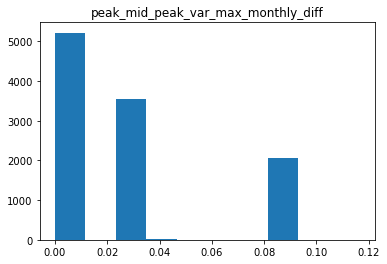

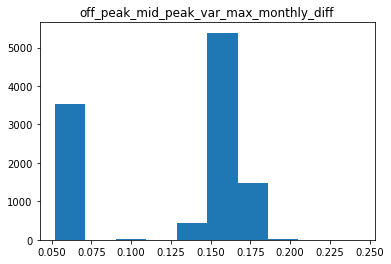

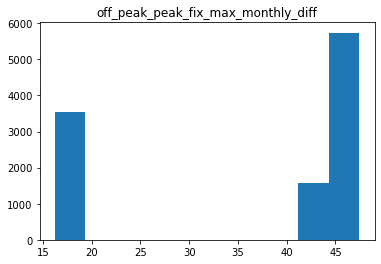

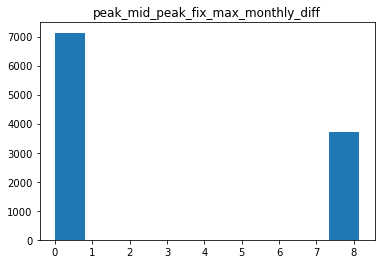

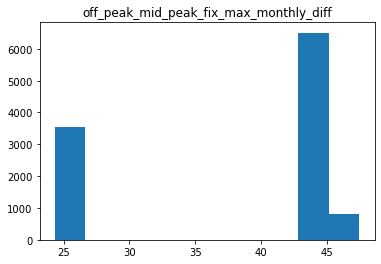

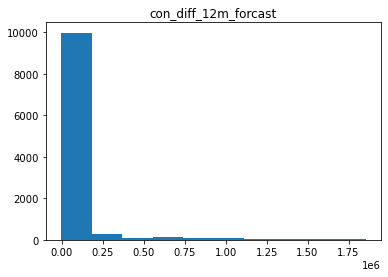

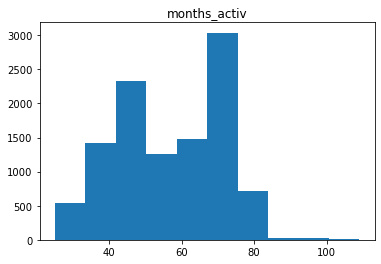

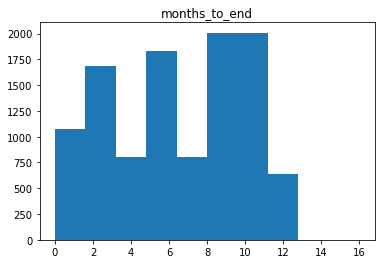

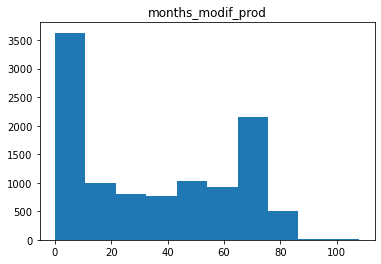

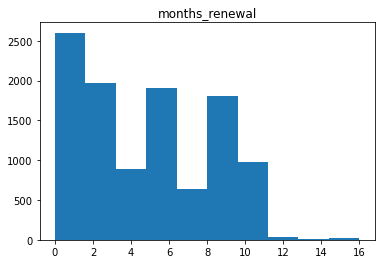

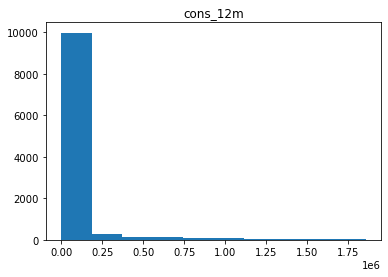

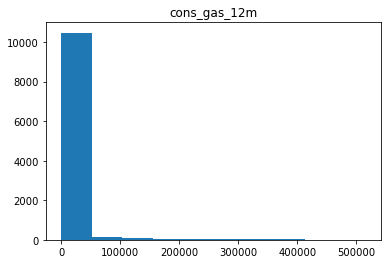

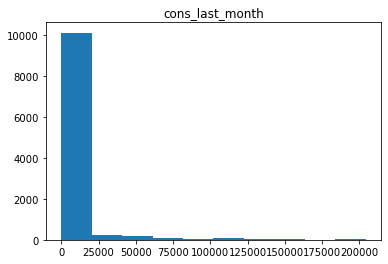

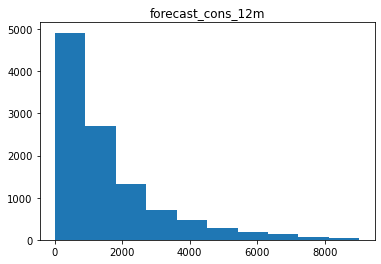

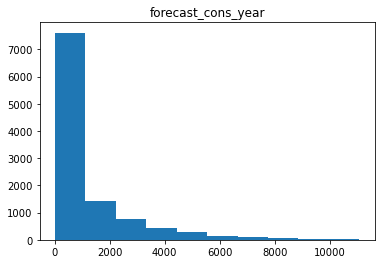

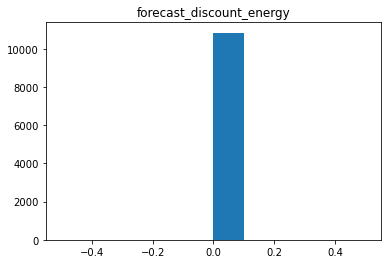

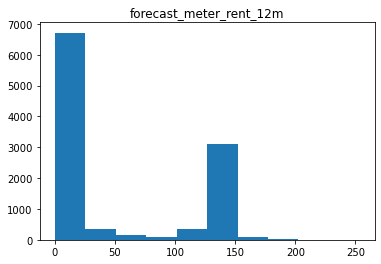

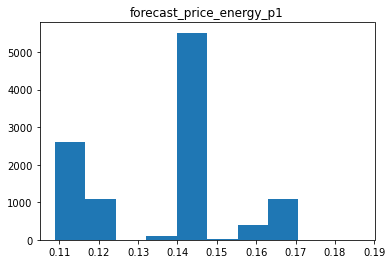

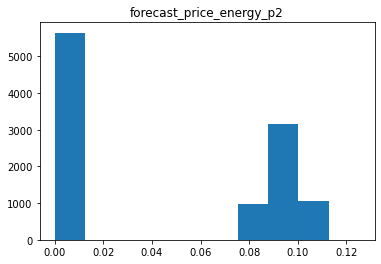

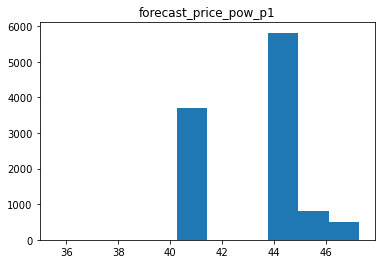

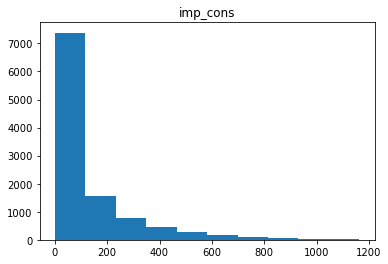

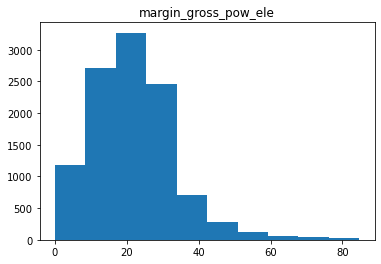

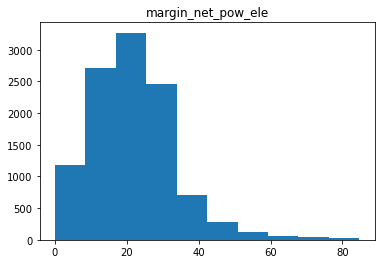

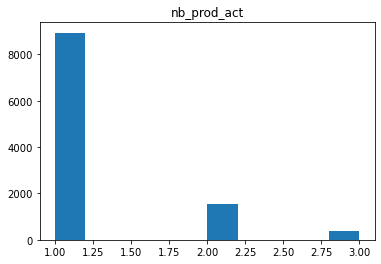

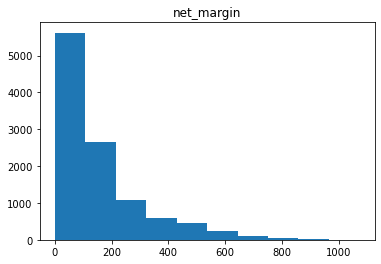

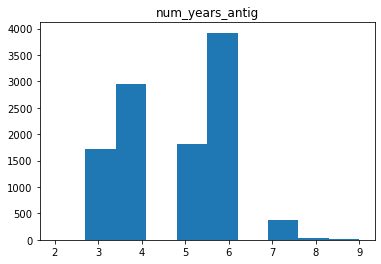

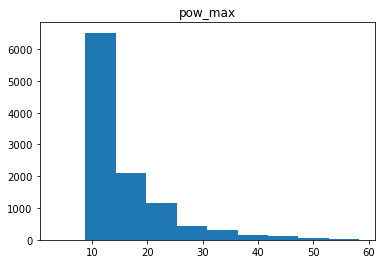

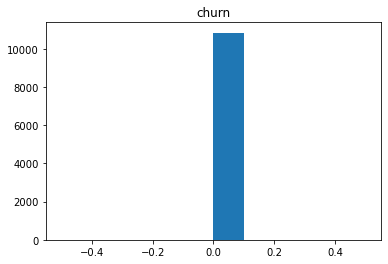

In [1378]:
#distribution after removing outliers
for col in df_ana_num.iloc[:, :-1].columns:
    plt.hist(df_ana_num[col])
    plt.title(col)
    plt.show()

In [1379]:
df_ana_num

,offpeak_diff_dec_january_energy,offpeak_diff_dec_january_power,peak_diff_dec_january_energy,peak_diff_dec_january_power,midpeak_diff_dec_january_energy,midpeak_diff_dec_january_power,off_peak_peak_var_mean_diff,peak_mid_peak_var_mean_diff,off_peak_mid_peak_var_mean_diff,off_peak_peak_fix_mean_diff,...,forecast_price_pow_p1,imp_cons,margin_gross_pow_ele,margin_net_pow_ele,nb_prod_act,net_margin,num_years_antig,pow_max,churn,id
0,-0.00619,0.16292,-0.00230,0.09775,0.00349,0.06517,0.02054,0.03063,0.05118,16.28069,...,40.60670,40.78000,43.08000,43.08000,1.00000,81.42000,6.00000,17.25000,0.00000,0002203ffbb812588b632b9e628cc38d
1,-0.00410,0.17778,0.00000,0.00000,0.00000,0.00000,0.14643,0.00000,0.14643,44.38545,...,44.31138,0.00000,24.42000,24.42000,1.00000,61.58000,6.00000,13.20000,0.00000,0004351ebdd665e6ee664792efc4fd13
4,-0.00399,-0.00000,0.00000,0.00000,0.00000,0.00000,0.14793,0.00000,0.14793,44.26693,...,44.31138,0.00000,29.76000,29.76000,1.00000,157.99000,6.00000,13.20000,0.00000,00114d74e963e47177db89bc70108537
6,-0.00617,0.00000,-0.00235,0.00000,0.00337,0.00000,0.02053,0.03062,0.05116,16.29155,...,40.60670,195.20000,30.00000,30.00000,1.00000,341.58000,3.00000,20.00000,0.00000,0013f326a839a2f6ad87a1859952d227
7,-0.00411,-0.00000,0.00000,0.00000,0.00000,0.00000,0.14764,0.00000,0.14764,44.26693,...,44.31138,798.16000,29.76000,29.76000,1.00000,184.06000,3.00000,13.20000,0.00000,00184e957277eeef733a7b563fdabd06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16088,-0.00625,0.17778,0.00000,0.00000,0.00000,0.00000,0.13981,0.00712,0.14694,44.34101,...,44.31138,0.00000,10.08000,10.08000,1.00000,43.62000,3.00000,10.39000,0.00000,ffe255be491c6576c37e257608ab4c02
16089,-0.00806,0.00000,0.00000,0.00000,0.00000,0.00000,0.15082,0.00000,0.15082,44.44471,...,44.31138,0.00000,32.88000,32.88000,1.00000,130.92000,5.00000,13.15000,0.00000,ffebf3f48e6728e2f688073b77ad8703
16092,-0.00378,0.17778,0.00000,0.00000,0.00000,0.00000,0.14714,0.00000,0.14714,44.31138,...,44.31138,0.00000,12.98000,12.98000,1.00000,191.60000,5.00000,15.00000,0.00000,fffac626da707b1b5ab11e8431a4d0a2
16094,-0.00939,0.16292,-0.00494,0.09775,0.00103,0.06517,0.02036,0.02976,0.05012,16.24268,...,40.60670,487.59000,19.68000,19.68000,3.00000,361.40000,4.00000,31.50000,0.00000,fffe4f5646aa39c7f97f95ae2679ce64


In [1380]:
df_ana_num_1= df_ana_num.copy()

In [1381]:
df = df_ana_num_1.drop_duplicates()
unique_labels = df.index.unique()
df_ana_num_1 = df.reindex(unique_labels)
df_ana_num_1 = df.reset_index(drop= True)

In [1382]:
df_ana_num=  df_ana_num_1.copy()

#### Skewness

In [1383]:
df_ana_num.columns

Index(['offpeak_diff_dec_january_energy', 'offpeak_diff_dec_january_power',
       'peak_diff_dec_january_energy', 'peak_diff_dec_january_power',
       'midpeak_diff_dec_january_energy', 'midpeak_diff_dec_january_power',
       'off_peak_peak_var_mean_diff', 'peak_mid_peak_var_mean_diff',
       'off_peak_mid_peak_var_mean_diff', 'off_peak_peak_fix_mean_diff',
       'peak_mid_peak_fix_mean_diff', 'off_peak_mid_peak_fix_mean_diff',
       'off_peak_peak_var_max_monthly_diff',
       'peak_mid_peak_var_max_monthly_diff',
       'off_peak_mid_peak_var_max_monthly_diff',
       'off_peak_peak_fix_max_monthly_diff',
       'peak_mid_peak_fix_max_monthly_diff',
       'off_peak_mid_peak_fix_max_monthly_diff', 'con_diff_12m_forcast',
       'months_activ', 'months_to_end', 'months_modif_prod', 'months_renewal',
       'cons_12m', 'cons_gas_12m', 'cons_last_month', 'forecast_cons_12m',
       'forecast_cons_year', 'forecast_discount_energy',
       'forecast_meter_rent_12m', 'forecast_price_

In [1384]:
#check skewness, any std>1 or < -1 is considered as skewed data
skewed = [
    'cons_12m', 
    'cons_gas_12m', 
    'cons_last_month',
    'forecast_cons_12m', 
    'forecast_cons_year', 
    'forecast_discount_energy',
    'forecast_meter_rent_12m', 
    'forecast_price_energy_p1',
    'forecast_price_energy_p2', 
    'forecast_price_pow_p1',
    'imp_cons', 'pow_max', 'net_margin', 
    'margin_net_pow_ele', 'margin_gross_pow_ele',
    'imp_cons'
]

df_ana_num[skewed].describe()

,cons_12m,cons_gas_12m,cons_last_month,forecast_cons_12m,forecast_cons_year,forecast_discount_energy,forecast_meter_rent_12m,forecast_price_energy_p1,forecast_price_energy_p2,forecast_price_pow_p1,imp_cons,pow_max,net_margin,margin_net_pow_ele,margin_gross_pow_ele,imp_cons
count,10844.00000,10844.00000,10844.00000,10844.00000,10844.00000,10844.00000,10844.00000,10844.00000,10844.00000,10844.00000,10844.00000,10844.00000,10844.00000,10844.00000,10844.00000,10844.00000
mean,77058.42005,7355.50148,6663.68167,1572.45103,1032.08244,0.00000,55.95304,0.13745,0.04601,43.24645,114.49565,16.16642,156.83352,21.79891,21.79891,114.49565
std,231776.62649,37605.78724,21954.71252,1574.93220,1654.03370,0.00000,56.10478,0.01705,0.04815,1.93940,178.76986,7.23567,158.29735,11.73393,11.73393,178.76986
min,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.10888,0.00000,35.55577,0.00000,3.30000,0.00000,0.00000,0.00000,0.00000
25%,5235.75000,0.00000,0.00000,484.55750,0.00000,0.00000,16.13000,0.11690,0.00000,40.60670,0.00000,12.10000,47.75000,14.01750,14.01750,0.00000
50%,12401.50000,0.00000,620.00000,1030.10000,231.00000,0.00000,18.41000,0.14346,0.00000,44.31138,29.17500,13.85600,102.16000,21.11000,21.11000,29.17500
75%,32106.50000,0.00000,2657.25000,2091.93000,1413.00000,0.00000,129.72000,0.14588,0.09884,44.31138,163.21500,17.30000,205.96500,27.99250,27.99250,163.21500
max,1856956.00000,515994.00000,204152.00000,9027.19000,11079.00000,0.00000,253.15000,0.18619,0.12538,47.30238,1162.89000,58.30000,1072.95000,84.70000,84.70000,1162.89000


In [1385]:
skewed = [
    'cons_12m', 
    'cons_gas_12m', 
    'cons_last_month',
    'forecast_cons_12m', 
    'forecast_cons_year', 
    'forecast_discount_energy',
    'forecast_meter_rent_12m', 
    'forecast_price_pow_p1',
    'imp_cons', 'pow_max', 'net_margin', 
    'margin_net_pow_ele', 'margin_gross_pow_ele',
    'imp_cons'
]

df_ana_num[skewed].describe()

,cons_12m,cons_gas_12m,cons_last_month,forecast_cons_12m,forecast_cons_year,forecast_discount_energy,forecast_meter_rent_12m,forecast_price_pow_p1,imp_cons,pow_max,net_margin,margin_net_pow_ele,margin_gross_pow_ele,imp_cons
count,10844.00000,10844.00000,10844.00000,10844.00000,10844.00000,10844.00000,10844.00000,10844.00000,10844.00000,10844.00000,10844.00000,10844.00000,10844.00000,10844.00000
mean,77058.42005,7355.50148,6663.68167,1572.45103,1032.08244,0.00000,55.95304,43.24645,114.49565,16.16642,156.83352,21.79891,21.79891,114.49565
std,231776.62649,37605.78724,21954.71252,1574.93220,1654.03370,0.00000,56.10478,1.93940,178.76986,7.23567,158.29735,11.73393,11.73393,178.76986
min,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,35.55577,0.00000,3.30000,0.00000,0.00000,0.00000,0.00000
25%,5235.75000,0.00000,0.00000,484.55750,0.00000,0.00000,16.13000,40.60670,0.00000,12.10000,47.75000,14.01750,14.01750,0.00000
50%,12401.50000,0.00000,620.00000,1030.10000,231.00000,0.00000,18.41000,44.31138,29.17500,13.85600,102.16000,21.11000,21.11000,29.17500
75%,32106.50000,0.00000,2657.25000,2091.93000,1413.00000,0.00000,129.72000,44.31138,163.21500,17.30000,205.96500,27.99250,27.99250,163.21500
max,1856956.00000,515994.00000,204152.00000,9027.19000,11079.00000,0.00000,253.15000,47.30238,1162.89000,58.30000,1072.95000,84.70000,84.70000,1162.89000


In [1386]:
for col in skewed:
    df_ana_num[col]= np.log10(df_ana_num[col]+1) 
df_ana_num

,offpeak_diff_dec_january_energy,offpeak_diff_dec_january_power,peak_diff_dec_january_energy,peak_diff_dec_january_power,midpeak_diff_dec_january_energy,midpeak_diff_dec_january_power,off_peak_peak_var_mean_diff,peak_mid_peak_var_mean_diff,off_peak_mid_peak_var_mean_diff,off_peak_peak_fix_mean_diff,...,forecast_price_pow_p1,imp_cons,margin_gross_pow_ele,margin_net_pow_ele,nb_prod_act,net_margin,num_years_antig,pow_max,churn,id
0,-0.00619,0.16292,-0.00230,0.09775,0.00349,0.06517,0.02054,0.03063,0.05118,16.28069,...,1.61916,0.41846,1.64424,1.64424,1.00000,1.91603,6.00000,1.26126,0.00000,0002203ffbb812588b632b9e628cc38d
1,-0.00410,0.17778,0.00000,0.00000,0.00000,0.00000,0.14643,0.00000,0.14643,44.38545,...,1.65621,0.00000,1.40518,1.40518,1.00000,1.79644,6.00000,1.15229,0.00000,0004351ebdd665e6ee664792efc4fd13
2,-0.00399,-0.00000,0.00000,0.00000,0.00000,0.00000,0.14793,0.00000,0.14793,44.26693,...,1.65621,0.00000,1.48799,1.48799,1.00000,2.20137,6.00000,1.15229,0.00000,00114d74e963e47177db89bc70108537
3,-0.00617,0.00000,-0.00235,0.00000,0.00337,0.00000,0.02053,0.03062,0.05116,16.29155,...,1.61916,0.51755,1.49136,1.49136,1.00000,2.53476,3.00000,1.32222,0.00000,0013f326a839a2f6ad87a1859952d227
4,-0.00411,-0.00000,0.00000,0.00000,0.00000,0.00000,0.14764,0.00000,0.14764,44.26693,...,1.65621,0.59136,1.48799,1.48799,1.00000,2.26731,3.00000,1.15229,0.00000,00184e957277eeef733a7b563fdabd06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10839,-0.00625,0.17778,0.00000,0.00000,0.00000,0.00000,0.13981,0.00712,0.14694,44.34101,...,1.65621,0.00000,1.04454,1.04454,1.00000,1.64953,3.00000,1.05652,0.00000,ffe255be491c6576c37e257608ab4c02
10840,-0.00806,0.00000,0.00000,0.00000,0.00000,0.00000,0.15082,0.00000,0.15082,44.44471,...,1.65621,0.00000,1.52994,1.52994,1.00000,2.12031,5.00000,1.15076,0.00000,ffebf3f48e6728e2f688073b77ad8703
10841,-0.00378,0.17778,0.00000,0.00000,0.00000,0.00000,0.14714,0.00000,0.14714,44.31138,...,1.65621,0.00000,1.14551,1.14551,1.00000,2.28466,5.00000,1.20412,0.00000,fffac626da707b1b5ab11e8431a4d0a2
10842,-0.00939,0.16292,-0.00494,0.09775,0.00103,0.06517,0.02036,0.02976,0.05012,16.24268,...,1.61916,0.56690,1.31555,1.31555,3.00000,2.55919,4.00000,1.51188,0.00000,fffe4f5646aa39c7f97f95ae2679ce64


In [1387]:
df_ana_num[skewed].describe()

,cons_12m,cons_gas_12m,cons_last_month,forecast_cons_12m,forecast_cons_year,forecast_discount_energy,forecast_meter_rent_12m,forecast_price_pow_p1,imp_cons,pow_max,net_margin,margin_net_pow_ele,margin_gross_pow_ele,imp_cons
count,10844.00000,10844.00000,10844.00000,10844.00000,10844.00000,10844.00000,10844.00000,10844.00000,10844.00000,10844.00000,10844.00000,10844.00000,10844.00000,10844.00000
mean,4.14209,0.61102,2.10614,2.95264,1.68373,0.00000,1.48386,1.64546,0.27009,1.20728,1.97039,1.28800,1.28800,0.27009
std,0.77222,1.49931,1.70759,0.57533,1.55453,0.00000,0.54318,0.01924,0.24747,0.14325,0.50876,0.27796,0.27796,0.24747
min,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,1.56296,0.00000,0.63347,0.00000,0.00000,0.00000,0.00000
25%,3.71906,0.00000,0.00000,2.68624,0.00000,0.00000,1.23376,1.61916,0.00000,1.11727,1.68797,1.17660,1.17660,0.00000
50%,4.09351,0.00000,2.79309,3.01330,2.36549,0.00000,1.28803,1.65621,0.39439,1.17190,2.01351,1.34459,1.34459,0.39439
75%,4.50661,0.00000,3.42460,3.32075,3.15045,0.00000,2.11634,1.65621,0.50724,1.26245,2.31590,1.46229,1.46229,0.50724
max,6.26880,5.71265,5.30996,3.95560,4.04454,0.00000,2.40509,1.68397,0.60916,1.77305,3.03098,1.93298,1.93298,0.60916


In [1388]:
import seaborn as sns

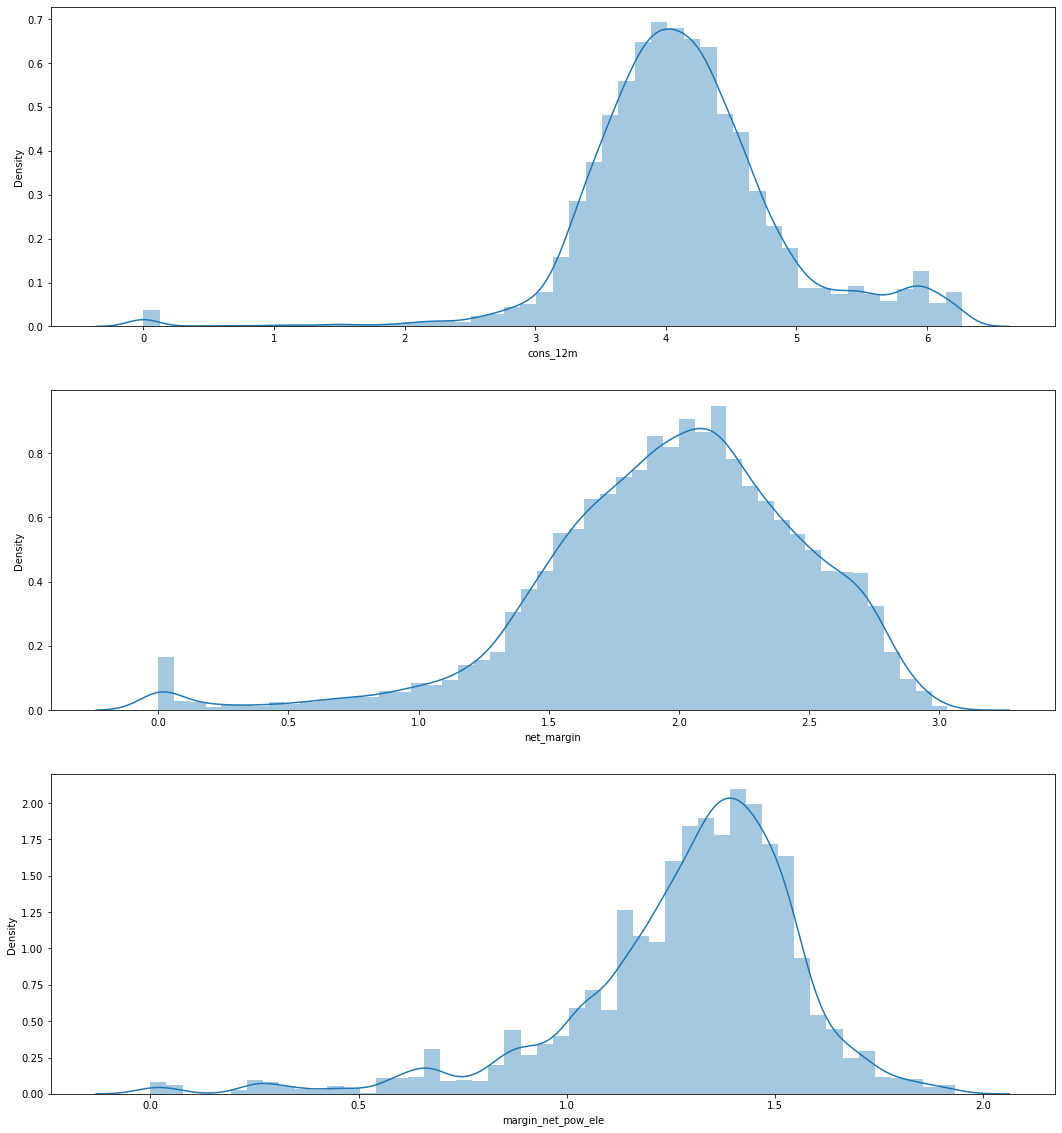

In [1389]:
fig, axs = plt.subplots(nrows=3, figsize=(18, 20))
# Plot histograms
sns.distplot((df_ana_num["cons_12m"].dropna()), ax=axs[0])
sns.distplot((df_ana_num["net_margin"].dropna()), ax=axs[1])
sns.distplot((df_ana_num["margin_net_pow_ele"].dropna()), ax=axs[2])
plt.show()

In [1390]:
df_ana_num

,offpeak_diff_dec_january_energy,offpeak_diff_dec_january_power,peak_diff_dec_january_energy,peak_diff_dec_january_power,midpeak_diff_dec_january_energy,midpeak_diff_dec_january_power,off_peak_peak_var_mean_diff,peak_mid_peak_var_mean_diff,off_peak_mid_peak_var_mean_diff,off_peak_peak_fix_mean_diff,...,forecast_price_pow_p1,imp_cons,margin_gross_pow_ele,margin_net_pow_ele,nb_prod_act,net_margin,num_years_antig,pow_max,churn,id
0,-0.00619,0.16292,-0.00230,0.09775,0.00349,0.06517,0.02054,0.03063,0.05118,16.28069,...,1.61916,0.41846,1.64424,1.64424,1.00000,1.91603,6.00000,1.26126,0.00000,0002203ffbb812588b632b9e628cc38d
1,-0.00410,0.17778,0.00000,0.00000,0.00000,0.00000,0.14643,0.00000,0.14643,44.38545,...,1.65621,0.00000,1.40518,1.40518,1.00000,1.79644,6.00000,1.15229,0.00000,0004351ebdd665e6ee664792efc4fd13
2,-0.00399,-0.00000,0.00000,0.00000,0.00000,0.00000,0.14793,0.00000,0.14793,44.26693,...,1.65621,0.00000,1.48799,1.48799,1.00000,2.20137,6.00000,1.15229,0.00000,00114d74e963e47177db89bc70108537
3,-0.00617,0.00000,-0.00235,0.00000,0.00337,0.00000,0.02053,0.03062,0.05116,16.29155,...,1.61916,0.51755,1.49136,1.49136,1.00000,2.53476,3.00000,1.32222,0.00000,0013f326a839a2f6ad87a1859952d227
4,-0.00411,-0.00000,0.00000,0.00000,0.00000,0.00000,0.14764,0.00000,0.14764,44.26693,...,1.65621,0.59136,1.48799,1.48799,1.00000,2.26731,3.00000,1.15229,0.00000,00184e957277eeef733a7b563fdabd06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10839,-0.00625,0.17778,0.00000,0.00000,0.00000,0.00000,0.13981,0.00712,0.14694,44.34101,...,1.65621,0.00000,1.04454,1.04454,1.00000,1.64953,3.00000,1.05652,0.00000,ffe255be491c6576c37e257608ab4c02
10840,-0.00806,0.00000,0.00000,0.00000,0.00000,0.00000,0.15082,0.00000,0.15082,44.44471,...,1.65621,0.00000,1.52994,1.52994,1.00000,2.12031,5.00000,1.15076,0.00000,ffebf3f48e6728e2f688073b77ad8703
10841,-0.00378,0.17778,0.00000,0.00000,0.00000,0.00000,0.14714,0.00000,0.14714,44.31138,...,1.65621,0.00000,1.14551,1.14551,1.00000,2.28466,5.00000,1.20412,0.00000,fffac626da707b1b5ab11e8431a4d0a2
10842,-0.00939,0.16292,-0.00494,0.09775,0.00103,0.06517,0.02036,0.02976,0.05012,16.24268,...,1.61916,0.56690,1.31555,1.31555,3.00000,2.55919,4.00000,1.51188,0.00000,fffe4f5646aa39c7f97f95ae2679ce64


In [1391]:
#new_df = pd.concat([new_df, df_ana_num_1['id']], axis=1)

In [1392]:
#mask = df_ana_num.iloc[:, :-1] < 1
#df_ana_num.iloc[:, :-1][mask]

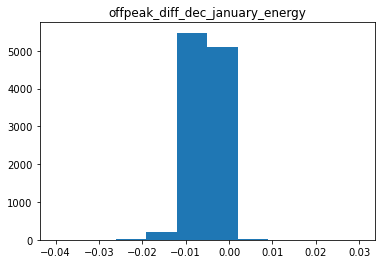

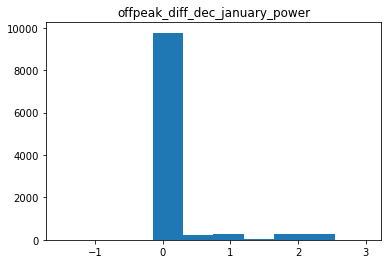

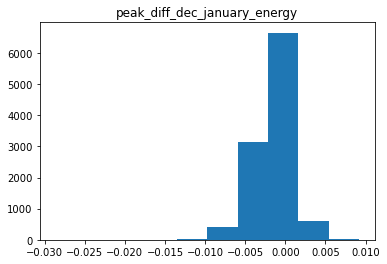

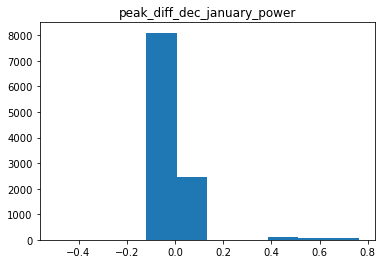

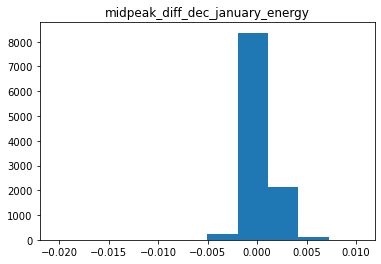

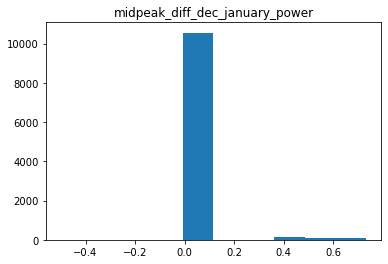

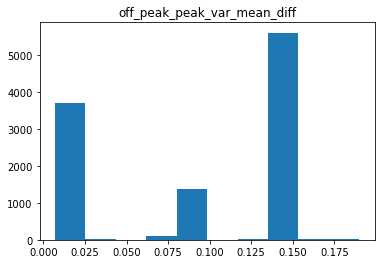

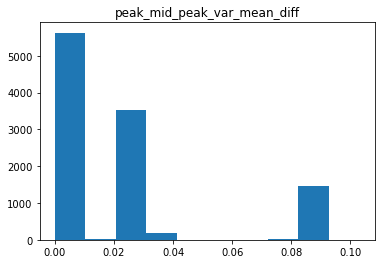

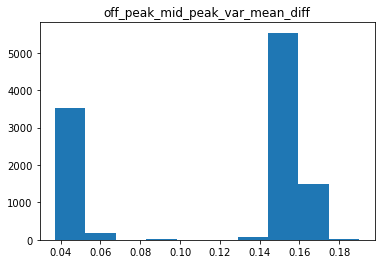

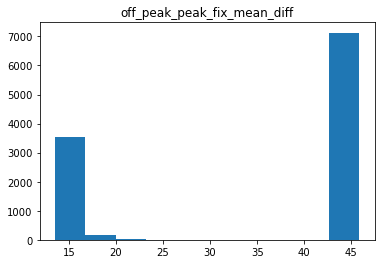

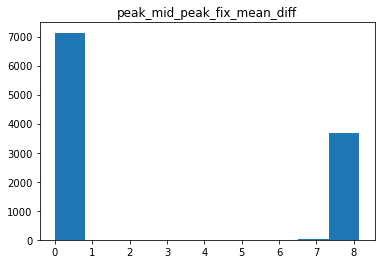

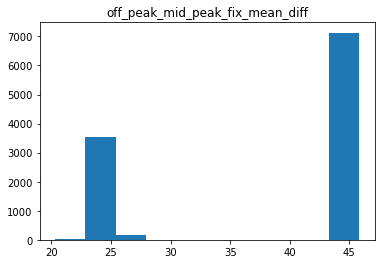

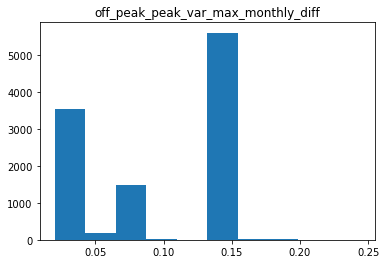

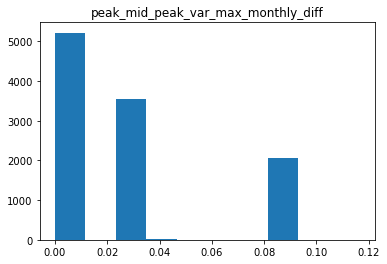

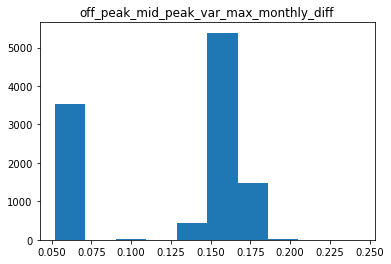

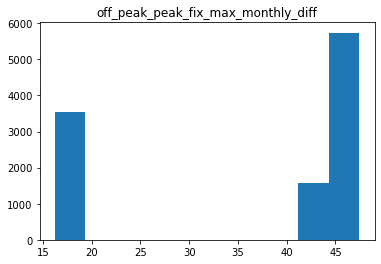

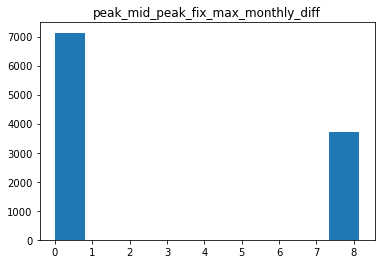

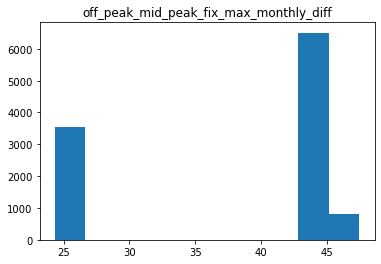

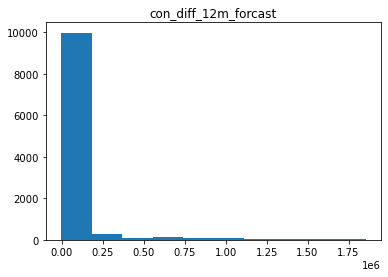

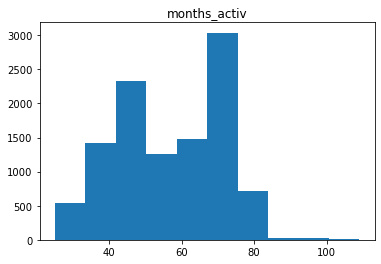

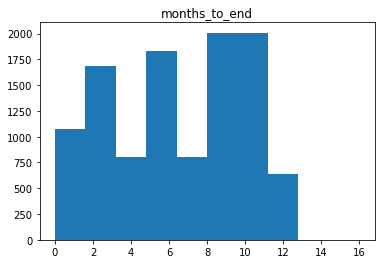

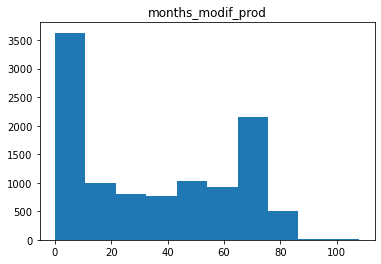

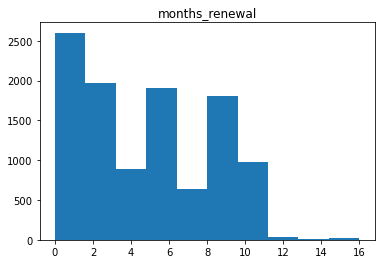

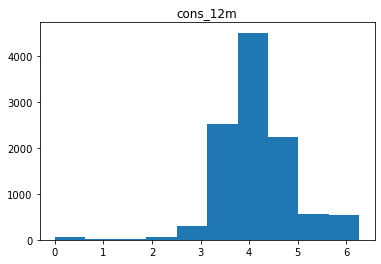

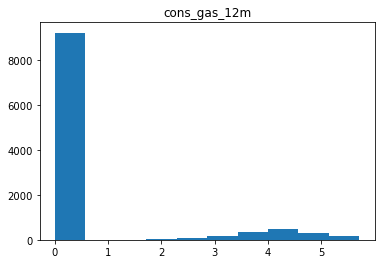

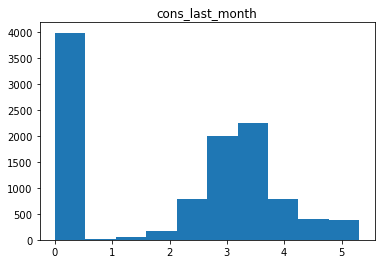

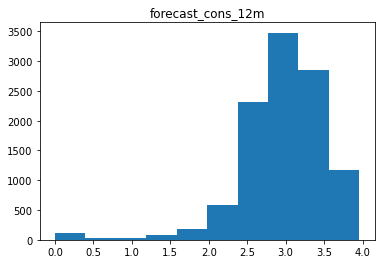

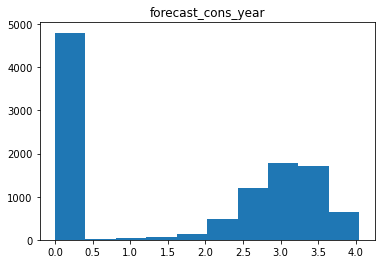

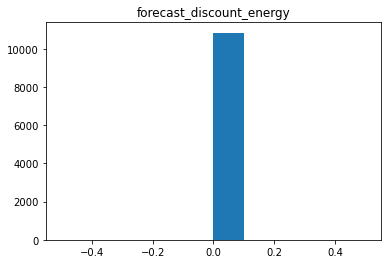

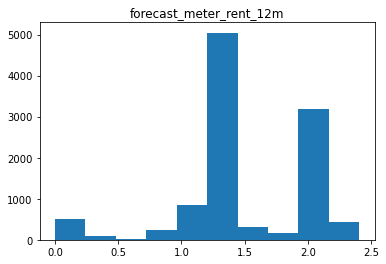

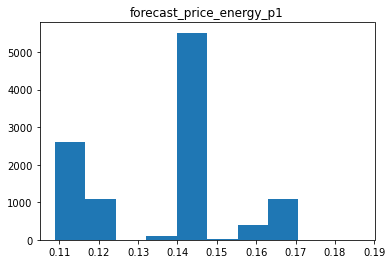

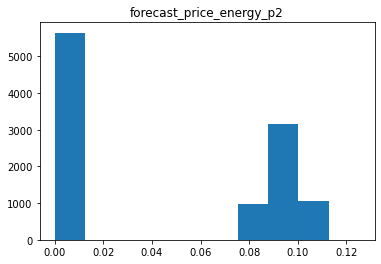

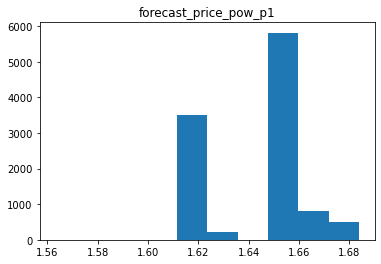

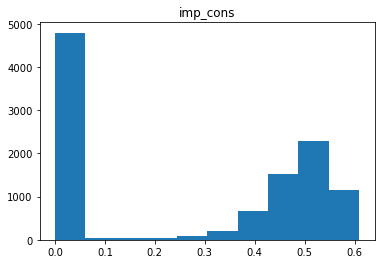

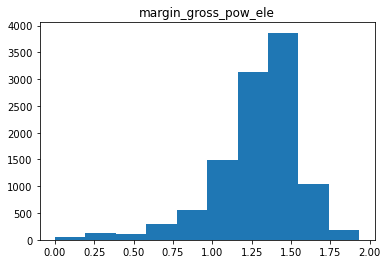

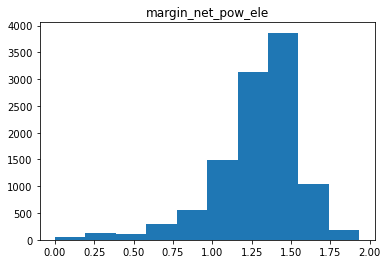

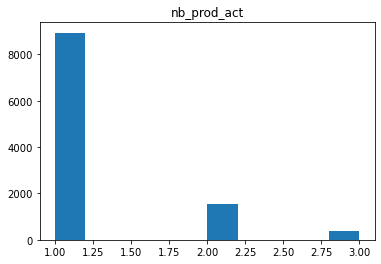

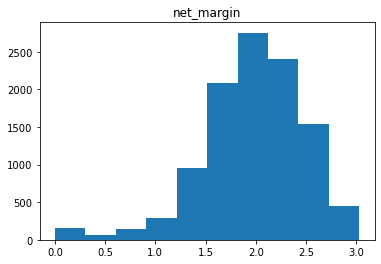

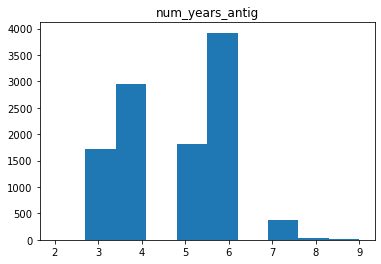

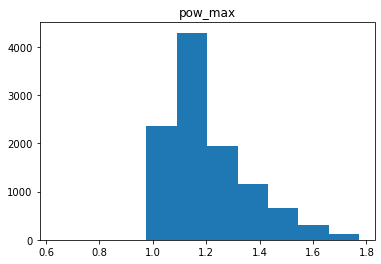

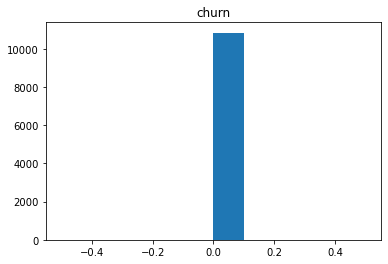

In [1393]:
#distribution after using log-transformation
for col in df_ana_num.iloc[:, :-1].columns:
    plt.hist(df_ana_num[col])
    plt.title(col)
    plt.show()

In [1394]:
col_cat= ['id', 'channel_sales', 'has_gas', 'origin_up', 'churn']
df_ana_cat= df_analysis[col_cat] 
df_ana_cat

,id,channel_sales,has_gas,origin_up,churn
0,0002203ffbb812588b632b9e628cc38d,foosdfpfkusacimwkcsosbicdxkicaua,f,kamkkxfxxuwbdslkwifmmcsiusiuosws,0.00000
1,0004351ebdd665e6ee664792efc4fd13,MISSING,f,kamkkxfxxuwbdslkwifmmcsiusiuosws,0.00000
2,0010bcc39e42b3c2131ed2ce55246e3c,usilxuppasemubllopkaafesmlibmsdf,f,lxidpiddsbxsbosboudacockeimpuepw,0.00000
4,00114d74e963e47177db89bc70108537,ewpakwlliwisiwduibdlfmalxowmwpci,f,kamkkxfxxuwbdslkwifmmcsiusiuosws,0.00000
6,0013f326a839a2f6ad87a1859952d227,foosdfpfkusacimwkcsosbicdxkicaua,f,lxidpiddsbxsbosboudacockeimpuepw,0.00000
...,...,...,...,...,...
16090,ffebf6a979dd0b17a41076df1057e733,lmkebamcaaclubfxadlmueccxoimlema,f,ldkssxwpmemidmecebumciepifcamkci,0.00000
16092,fffac626da707b1b5ab11e8431a4d0a2,ewpakwlliwisiwduibdlfmalxowmwpci,f,lxidpiddsbxsbosboudacockeimpuepw,0.00000
16093,fffc0cacd305dd51f316424bbb08d1bd,foosdfpfkusacimwkcsosbicdxkicaua,t,lxidpiddsbxsbosboudacockeimpuepw,0.00000
16094,fffe4f5646aa39c7f97f95ae2679ce64,MISSING,t,lxidpiddsbxsbosboudacockeimpuepw,0.00000


In [1395]:
df_analysis.select_dtypes(include='object')

,id,channel_sales,has_gas,origin_up
0,0002203ffbb812588b632b9e628cc38d,foosdfpfkusacimwkcsosbicdxkicaua,f,kamkkxfxxuwbdslkwifmmcsiusiuosws
1,0004351ebdd665e6ee664792efc4fd13,MISSING,f,kamkkxfxxuwbdslkwifmmcsiusiuosws
2,0010bcc39e42b3c2131ed2ce55246e3c,usilxuppasemubllopkaafesmlibmsdf,f,lxidpiddsbxsbosboudacockeimpuepw
4,00114d74e963e47177db89bc70108537,ewpakwlliwisiwduibdlfmalxowmwpci,f,kamkkxfxxuwbdslkwifmmcsiusiuosws
6,0013f326a839a2f6ad87a1859952d227,foosdfpfkusacimwkcsosbicdxkicaua,f,lxidpiddsbxsbosboudacockeimpuepw
...,...,...,...,...
16090,ffebf6a979dd0b17a41076df1057e733,lmkebamcaaclubfxadlmueccxoimlema,f,ldkssxwpmemidmecebumciepifcamkci
16092,fffac626da707b1b5ab11e8431a4d0a2,ewpakwlliwisiwduibdlfmalxowmwpci,f,lxidpiddsbxsbosboudacockeimpuepw
16093,fffc0cacd305dd51f316424bbb08d1bd,foosdfpfkusacimwkcsosbicdxkicaua,t,lxidpiddsbxsbosboudacockeimpuepw
16094,fffe4f5646aa39c7f97f95ae2679ce64,MISSING,t,lxidpiddsbxsbosboudacockeimpuepw


In [1396]:
# Transform into categorical type
df_analysis['channel_sales'] = df_analysis['channel_sales'].astype('category')

# Let's see how many categories are within this column
df_analysis['channel_sales'].value_counts()

foosdfpfkusacimwkcsosbicdxkicaua    6753
MISSING                             3725
lmkebamcaaclubfxadlmueccxoimlema    1843
usilxuppasemubllopkaafesmlibmsdf    1375
ewpakwlliwisiwduibdlfmalxowmwpci     893
sddiedcslfslkckwlfkdpoeeailfpeds      11
epumfxlbckeskwekxbiuasklxalciiuu       3
fixdbufsefwooaasfcxdxadsiekoceaa       2
Name: channel_sales, dtype: int64

In [1397]:
df_analysis.columns

Index(['id', 'offpeak_diff_dec_january_energy',
       'offpeak_diff_dec_january_power', 'peak_diff_dec_january_energy',
       'peak_diff_dec_january_power', 'midpeak_diff_dec_january_energy',
       'midpeak_diff_dec_january_power', 'off_peak_peak_var_mean_diff',
       'peak_mid_peak_var_mean_diff', 'off_peak_mid_peak_var_mean_diff',
       'off_peak_peak_fix_mean_diff', 'peak_mid_peak_fix_mean_diff',
       'off_peak_mid_peak_fix_mean_diff', 'off_peak_peak_var_max_monthly_diff',
       'peak_mid_peak_var_max_monthly_diff',
       'off_peak_mid_peak_var_max_monthly_diff',
       'off_peak_peak_fix_max_monthly_diff',
       'peak_mid_peak_fix_max_monthly_diff',
       'off_peak_mid_peak_fix_max_monthly_diff', 'con_diff_12m_forcast',
       'months_activ', 'months_to_end', 'months_modif_prod', 'months_renewal',
       'channel_sales', 'cons_12m', 'cons_gas_12m', 'cons_last_month',
       'forecast_cons_12m', 'forecast_cons_year', 'forecast_discount_energy',
       'forecast_meter_rent

In [1398]:
df_analysis = pd.get_dummies(df_analysis, columns=['channel_sales'], prefix='channel')
df_analysis = df_analysis.drop(columns=['channel_sddiedcslfslkckwlfkdpoeeailfpeds', 'channel_epumfxlbckeskwekxbiuasklxalciiuu', 'channel_fixdbufsefwooaasfcxdxadsiekoceaa'])
df_analysis  

,id,offpeak_diff_dec_january_energy,offpeak_diff_dec_january_power,peak_diff_dec_january_energy,peak_diff_dec_january_power,midpeak_diff_dec_january_energy,midpeak_diff_dec_january_power,off_peak_peak_var_mean_diff,peak_mid_peak_var_mean_diff,off_peak_mid_peak_var_mean_diff,...,net_margin,num_years_antig,origin_up,pow_max,churn,channel_MISSING,channel_ewpakwlliwisiwduibdlfmalxowmwpci,channel_foosdfpfkusacimwkcsosbicdxkicaua,channel_lmkebamcaaclubfxadlmueccxoimlema,channel_usilxuppasemubllopkaafesmlibmsdf
0,0002203ffbb812588b632b9e628cc38d,-0.00619,0.16292,-0.00230,0.09775,0.00349,0.06517,0.02054,0.03063,0.05118,...,81.42000,6.00000,kamkkxfxxuwbdslkwifmmcsiusiuosws,17.25000,0.00000,0,0,1,0,0
1,0004351ebdd665e6ee664792efc4fd13,-0.00410,0.17778,0.00000,0.00000,0.00000,0.00000,0.14643,0.00000,0.14643,...,61.58000,6.00000,kamkkxfxxuwbdslkwifmmcsiusiuosws,13.20000,0.00000,1,0,0,0,0
2,0010bcc39e42b3c2131ed2ce55246e3c,0.05044,1.50000,0.00000,0.00000,0.00000,0.00000,0.18156,0.00000,0.18156,...,81.61000,3.00000,lxidpiddsbxsbosboudacockeimpuepw,13.85600,0.00000,0,0,0,0,1
4,00114d74e963e47177db89bc70108537,-0.00399,-0.00000,0.00000,0.00000,0.00000,0.00000,0.14793,0.00000,0.14793,...,157.99000,6.00000,kamkkxfxxuwbdslkwifmmcsiusiuosws,13.20000,0.00000,0,1,0,0,0
6,0013f326a839a2f6ad87a1859952d227,-0.00617,0.00000,-0.00235,0.00000,0.00337,0.00000,0.02053,0.03062,0.05116,...,341.58000,3.00000,lxidpiddsbxsbosboudacockeimpuepw,20.00000,0.00000,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16090,ffebf6a979dd0b17a41076df1057e733,-0.01049,0.16292,-0.00481,0.09775,-0.00045,0.06517,0.02005,0.03016,0.05022,...,742.37000,11.00000,ldkssxwpmemidmecebumciepifcamkci,34.64000,0.00000,0,0,0,1,0
16092,fffac626da707b1b5ab11e8431a4d0a2,-0.00378,0.17778,0.00000,0.00000,0.00000,0.00000,0.14714,0.00000,0.14714,...,191.60000,5.00000,lxidpiddsbxsbosboudacockeimpuepw,15.00000,0.00000,0,1,0,0,0
16093,fffc0cacd305dd51f316424bbb08d1bd,-0.00176,0.16492,-0.00371,0.09975,-0.00733,0.06717,0.02438,0.03465,0.05904,...,351.39000,3.00000,lxidpiddsbxsbosboudacockeimpuepw,16.50000,0.00000,0,0,1,0,0
16094,fffe4f5646aa39c7f97f95ae2679ce64,-0.00939,0.16292,-0.00494,0.09775,0.00103,0.06517,0.02036,0.02976,0.05012,...,361.40000,4.00000,lxidpiddsbxsbosboudacockeimpuepw,31.50000,0.00000,1,0,0,0,0


In [1399]:
df_analysis.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14605 entries, 0 to 16095
Data columns (total 49 columns):
 #   Column                                    Non-Null Count  Dtype  
---  ------                                    --------------  -----  
 0   id                                        14605 non-null  object 
 1   offpeak_diff_dec_january_energy           14605 non-null  float64
 2   offpeak_diff_dec_january_power            14605 non-null  float64
 3   peak_diff_dec_january_energy              14605 non-null  float64
 4   peak_diff_dec_january_power               14605 non-null  float64
 5   midpeak_diff_dec_january_energy           14605 non-null  float64
 6   midpeak_diff_dec_january_power            14605 non-null  float64
 7   off_peak_peak_var_mean_diff               14605 non-null  float64
 8   peak_mid_peak_var_mean_diff               14605 non-null  float64
 9   off_peak_mid_peak_var_mean_diff           14605 non-null  float64
 10  off_peak_peak_fix_mean_diff       

In [1400]:
# Transform into categorical type
df_analysis['origin_up'] = df_analysis['origin_up'].astype('category')

# Let's see how many categories are within this column
df_analysis['origin_up'].value_counts()

lxidpiddsbxsbosboudacockeimpuepw    7096
kamkkxfxxuwbdslkwifmmcsiusiuosws    4294
ldkssxwpmemidmecebumciepifcamkci    3148
MISSING                               64
usapbepcfoloekilkwsdiboslwaxobdp       2
ewxeelcelemmiwuafmddpobolfuxioce       1
Name: origin_up, dtype: int64

In [1401]:
df_analysis = pd.get_dummies(df_analysis, columns=['origin_up'], prefix='origin')
df_analysis = df_analysis.drop(columns=['origin_MISSING', 'origin_usapbepcfoloekilkwsdiboslwaxobdp', 'origin_ewxeelcelemmiwuafmddpobolfuxioce'])
df_analysis  

,id,offpeak_diff_dec_january_energy,offpeak_diff_dec_january_power,peak_diff_dec_january_energy,peak_diff_dec_january_power,midpeak_diff_dec_january_energy,midpeak_diff_dec_january_power,off_peak_peak_var_mean_diff,peak_mid_peak_var_mean_diff,off_peak_mid_peak_var_mean_diff,...,pow_max,churn,channel_MISSING,channel_ewpakwlliwisiwduibdlfmalxowmwpci,channel_foosdfpfkusacimwkcsosbicdxkicaua,channel_lmkebamcaaclubfxadlmueccxoimlema,channel_usilxuppasemubllopkaafesmlibmsdf,origin_kamkkxfxxuwbdslkwifmmcsiusiuosws,origin_ldkssxwpmemidmecebumciepifcamkci,origin_lxidpiddsbxsbosboudacockeimpuepw
0,0002203ffbb812588b632b9e628cc38d,-0.00619,0.16292,-0.00230,0.09775,0.00349,0.06517,0.02054,0.03063,0.05118,...,17.25000,0.00000,0,0,1,0,0,1,0,0
1,0004351ebdd665e6ee664792efc4fd13,-0.00410,0.17778,0.00000,0.00000,0.00000,0.00000,0.14643,0.00000,0.14643,...,13.20000,0.00000,1,0,0,0,0,1,0,0
2,0010bcc39e42b3c2131ed2ce55246e3c,0.05044,1.50000,0.00000,0.00000,0.00000,0.00000,0.18156,0.00000,0.18156,...,13.85600,0.00000,0,0,0,0,1,0,0,1
4,00114d74e963e47177db89bc70108537,-0.00399,-0.00000,0.00000,0.00000,0.00000,0.00000,0.14793,0.00000,0.14793,...,13.20000,0.00000,0,1,0,0,0,1,0,0
6,0013f326a839a2f6ad87a1859952d227,-0.00617,0.00000,-0.00235,0.00000,0.00337,0.00000,0.02053,0.03062,0.05116,...,20.00000,0.00000,0,0,1,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16090,ffebf6a979dd0b17a41076df1057e733,-0.01049,0.16292,-0.00481,0.09775,-0.00045,0.06517,0.02005,0.03016,0.05022,...,34.64000,0.00000,0,0,0,1,0,0,1,0
16092,fffac626da707b1b5ab11e8431a4d0a2,-0.00378,0.17778,0.00000,0.00000,0.00000,0.00000,0.14714,0.00000,0.14714,...,15.00000,0.00000,0,1,0,0,0,0,0,1
16093,fffc0cacd305dd51f316424bbb08d1bd,-0.00176,0.16492,-0.00371,0.09975,-0.00733,0.06717,0.02438,0.03465,0.05904,...,16.50000,0.00000,0,0,1,0,0,0,0,1
16094,fffe4f5646aa39c7f97f95ae2679ce64,-0.00939,0.16292,-0.00494,0.09775,0.00103,0.06517,0.02036,0.02976,0.05012,...,31.50000,0.00000,1,0,0,0,0,0,0,1


In [1402]:
df_analysis['has_gas']

0        f
1        f
2        f
4        f
6        f
        ..
16090    f
16092    f
16093    t
16094    t
16095    f
Name: has_gas, Length: 14605, dtype: object

In [1403]:
df_analysis['has_gas']= df_analysis['has_gas'].replace(['t', 'f'], [1, 0])

In [1404]:
df_analysis

,id,offpeak_diff_dec_january_energy,offpeak_diff_dec_january_power,peak_diff_dec_january_energy,peak_diff_dec_january_power,midpeak_diff_dec_january_energy,midpeak_diff_dec_january_power,off_peak_peak_var_mean_diff,peak_mid_peak_var_mean_diff,off_peak_mid_peak_var_mean_diff,...,pow_max,churn,channel_MISSING,channel_ewpakwlliwisiwduibdlfmalxowmwpci,channel_foosdfpfkusacimwkcsosbicdxkicaua,channel_lmkebamcaaclubfxadlmueccxoimlema,channel_usilxuppasemubllopkaafesmlibmsdf,origin_kamkkxfxxuwbdslkwifmmcsiusiuosws,origin_ldkssxwpmemidmecebumciepifcamkci,origin_lxidpiddsbxsbosboudacockeimpuepw
0,0002203ffbb812588b632b9e628cc38d,-0.00619,0.16292,-0.00230,0.09775,0.00349,0.06517,0.02054,0.03063,0.05118,...,17.25000,0.00000,0,0,1,0,0,1,0,0
1,0004351ebdd665e6ee664792efc4fd13,-0.00410,0.17778,0.00000,0.00000,0.00000,0.00000,0.14643,0.00000,0.14643,...,13.20000,0.00000,1,0,0,0,0,1,0,0
2,0010bcc39e42b3c2131ed2ce55246e3c,0.05044,1.50000,0.00000,0.00000,0.00000,0.00000,0.18156,0.00000,0.18156,...,13.85600,0.00000,0,0,0,0,1,0,0,1
4,00114d74e963e47177db89bc70108537,-0.00399,-0.00000,0.00000,0.00000,0.00000,0.00000,0.14793,0.00000,0.14793,...,13.20000,0.00000,0,1,0,0,0,1,0,0
6,0013f326a839a2f6ad87a1859952d227,-0.00617,0.00000,-0.00235,0.00000,0.00337,0.00000,0.02053,0.03062,0.05116,...,20.00000,0.00000,0,0,1,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16090,ffebf6a979dd0b17a41076df1057e733,-0.01049,0.16292,-0.00481,0.09775,-0.00045,0.06517,0.02005,0.03016,0.05022,...,34.64000,0.00000,0,0,0,1,0,0,1,0
16092,fffac626da707b1b5ab11e8431a4d0a2,-0.00378,0.17778,0.00000,0.00000,0.00000,0.00000,0.14714,0.00000,0.14714,...,15.00000,0.00000,0,1,0,0,0,0,0,1
16093,fffc0cacd305dd51f316424bbb08d1bd,-0.00176,0.16492,-0.00371,0.09975,-0.00733,0.06717,0.02438,0.03465,0.05904,...,16.50000,0.00000,0,0,1,0,0,0,0,1
16094,fffe4f5646aa39c7f97f95ae2679ce64,-0.00939,0.16292,-0.00494,0.09775,0.00103,0.06517,0.02036,0.02976,0.05012,...,31.50000,0.00000,1,0,0,0,0,0,0,1


#### Feature scaling

In [1405]:
df_analysis = df_analysis.drop_duplicates()
unique_labels = df_analysis.index.unique()
df_analysis = df_analysis.reindex(unique_labels)
df_analysis = df_analysis.reset_index(drop= True)
df_analysis['churn']= df_analysis['churn'].astype('int')

In [1406]:
df_target= df_analysis['churn'] 
df_analysis.drop('churn', axis= 1, inplace= True)
df_analysis.drop('id', axis= 1, inplace= True )

In [1407]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
df_scaled = df_analysis.copy()  # make a copy of the original DataFrame
df_scaled.iloc[:, :41] = scaler.fit_transform(df_analysis.iloc[:, :41])

### Feature Selection

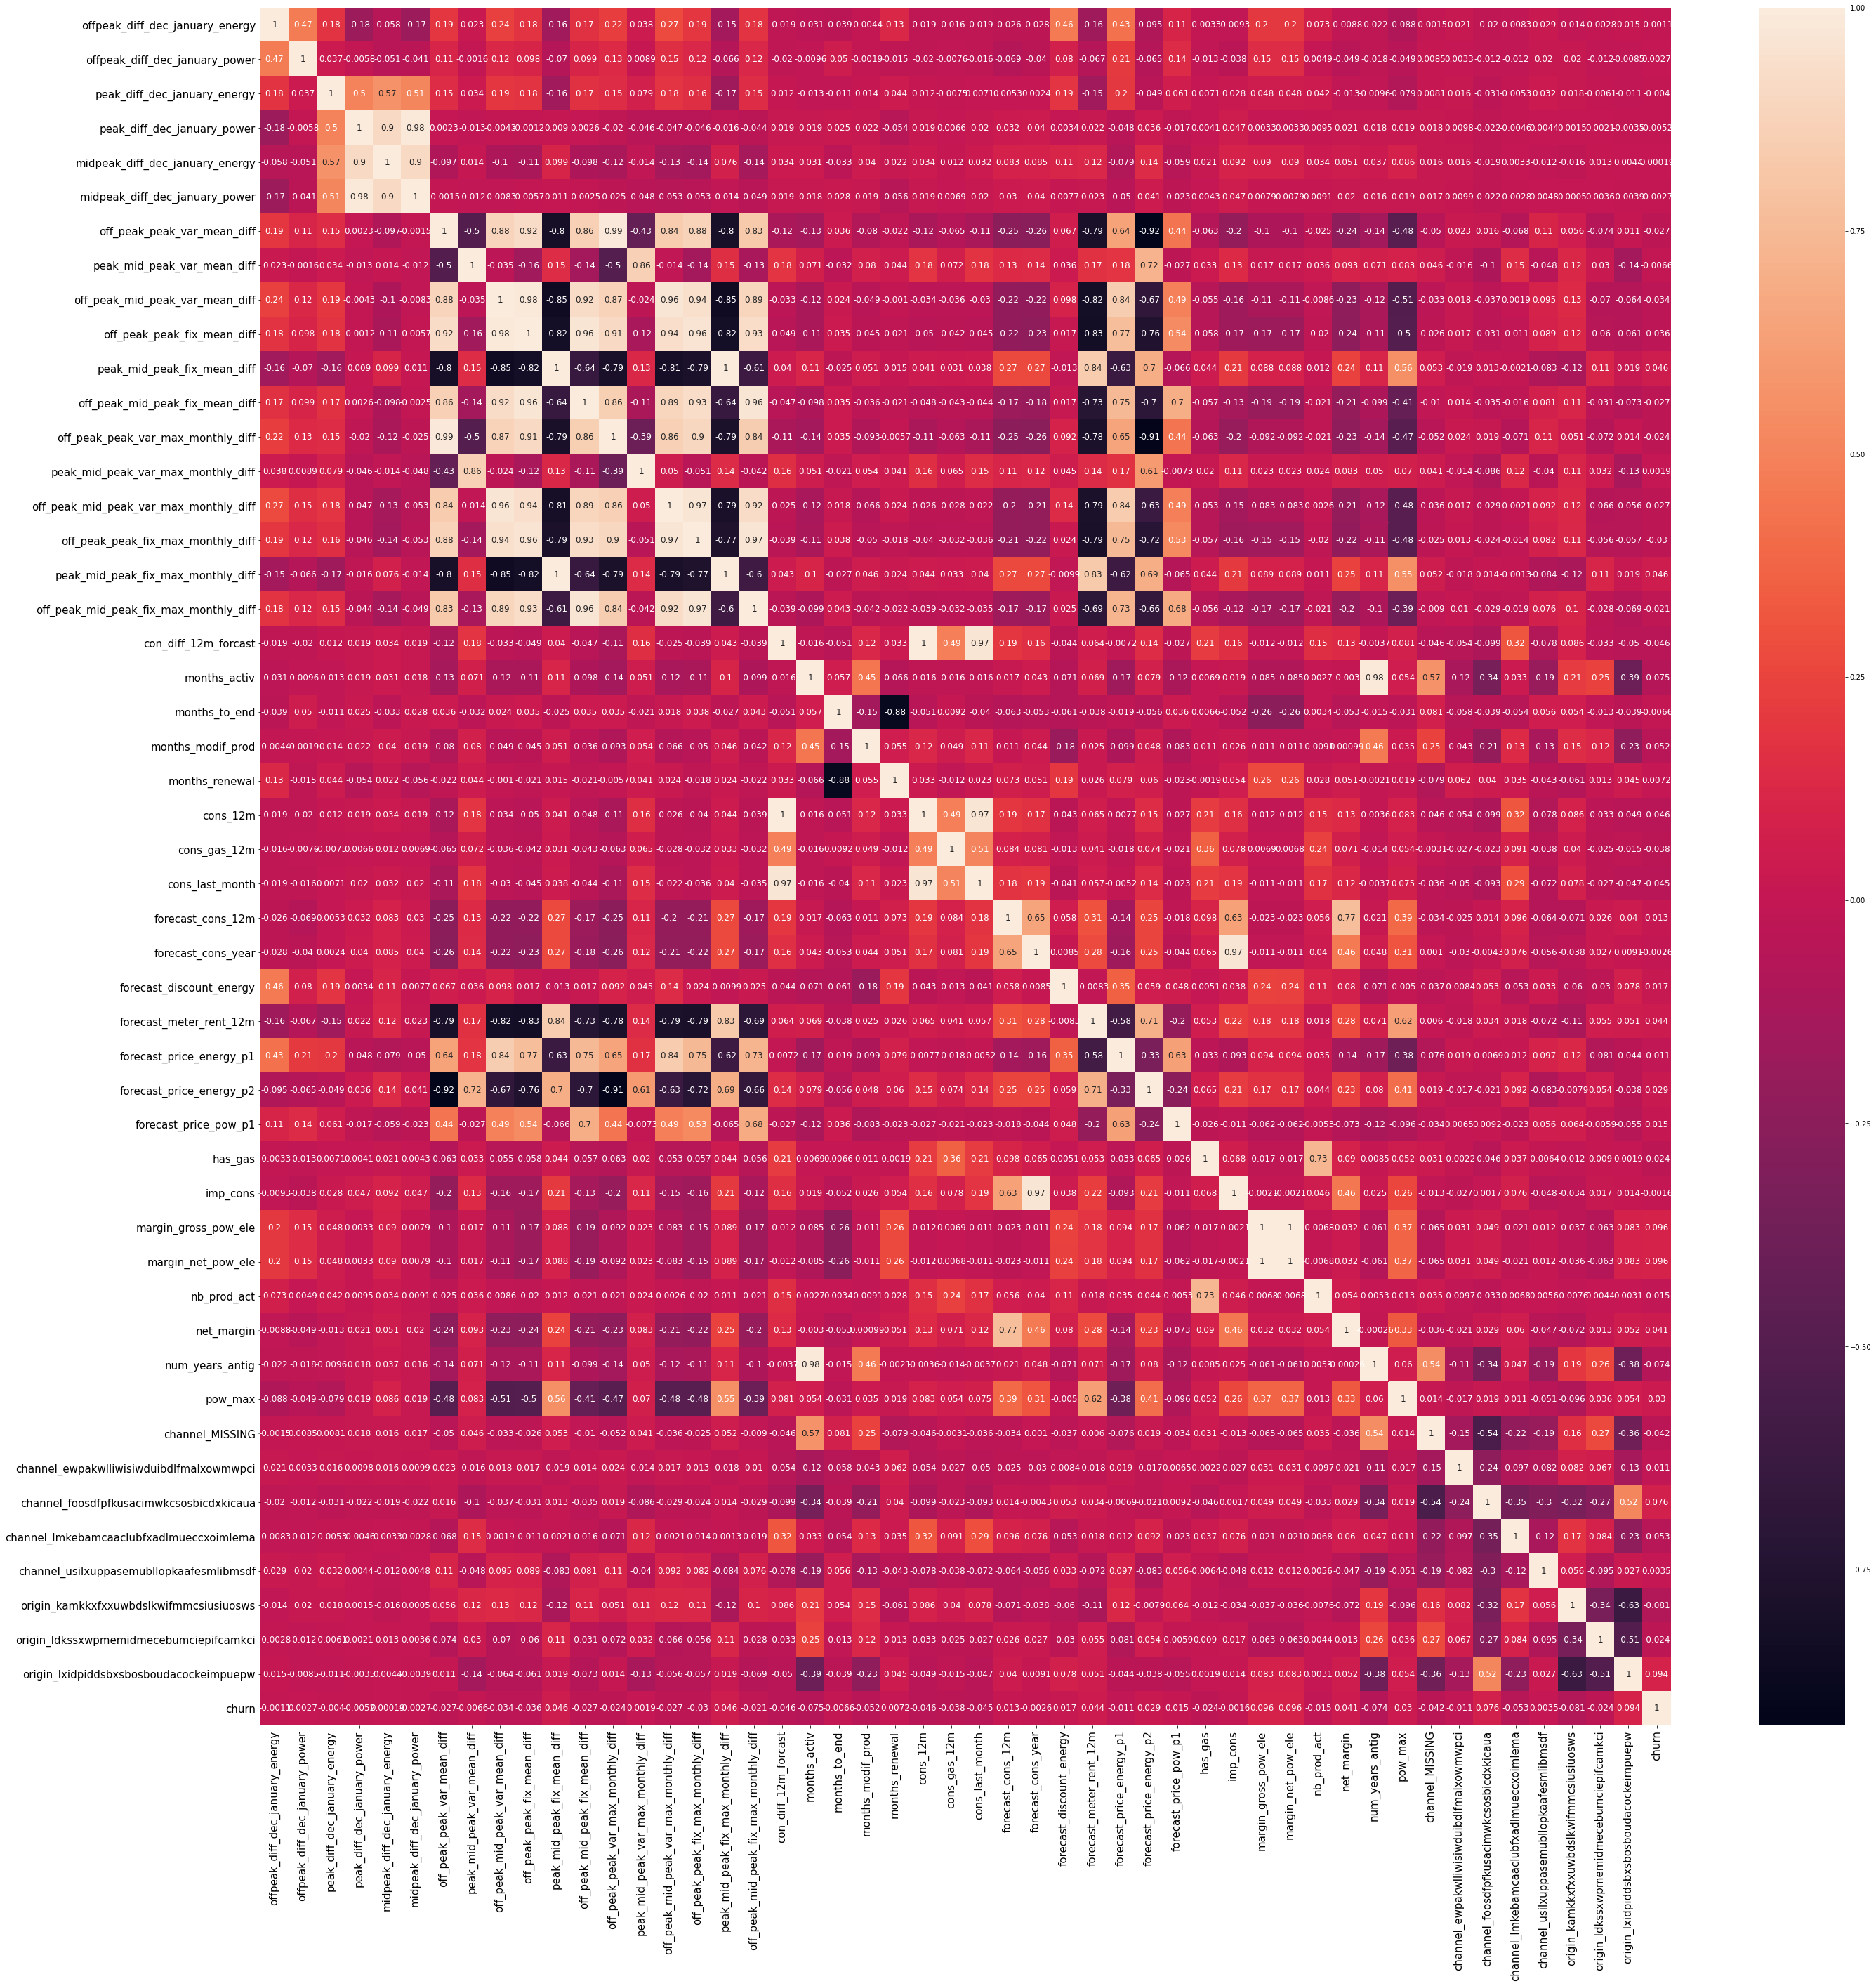

In [1408]:
# Plot correlation
correlation = pd.concat([df_scaled,df_target], axis= 1 ).corr()
plt.figure(figsize=(45, 45))
sns.heatmap(
    correlation, 
    xticklabels=correlation.columns.values,
    yticklabels=correlation.columns.values, 
    annot=True, 
    annot_kws={'size': 12}
)
# Axis ticks size
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.show()

In [1409]:
#chi squared feature selection
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
chi2val, pval = chi2(df_scaled, df_target )
(pval<0.1).sum() 

21

In [1431]:
kbest= SelectKBest(chi2, k=21).fit(df_scaled, df_target) #选择三个特征
# Get the indices of the selected features
selected_indices = kbest.get_support(indices=True)

# Get the names of the selected features
selected_features = df_scaled.columns[selected_indices]

# Print the names of the selected features
print(selected_features)

Index(['peak_mid_peak_fix_mean_diff', 'peak_mid_peak_fix_max_monthly_diff',
       'con_diff_12m_forcast', 'months_activ', 'months_modif_prod', 'cons_12m',
       'cons_gas_12m', 'cons_last_month', 'forecast_discount_energy',
       'forecast_meter_rent_12m', 'forecast_price_energy_p2', 'has_gas',
       'margin_gross_pow_ele', 'margin_net_pow_ele', 'num_years_antig',
       'channel_MISSING', 'channel_foosdfpfkusacimwkcsosbicdxkicaua',
       'channel_lmkebamcaaclubfxadlmueccxoimlema',
       'origin_kamkkxfxxuwbdslkwifmmcsiusiuosws',
       'origin_ldkssxwpmemidmecebumciepifcamkci',
       'origin_lxidpiddsbxsbosboudacockeimpuepw'],
      dtype='object')


---

## 4. Modeling

#### Data sampling

In [1433]:
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

In [1434]:
# Make a copy of our data
train_df = df_scaled.copy()

# Separate target variable from independent variables
y = df_target
X = df_scaled[selected_features]
print(X.shape)
print(y.shape)

(14605, 21)
(14605,)


In [1435]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42, stratify=y)
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)


(10953, 21)
(10953,)
(3652, 21)
(3652,)


#### Model training

In [1436]:
model = RandomForestClassifier(
    n_estimators=1000
)
model.fit(X_train, y_train)

RandomForestClassifier(n_estimators=1000)

#### Model evaluation

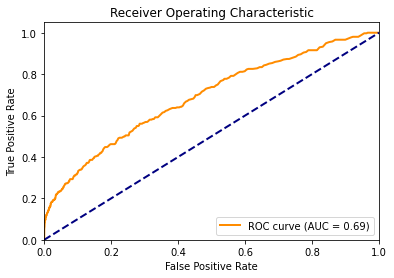

In [1437]:
from sklearn.metrics import roc_curve, auc

# Compute predicted probabilities
proba_predictions = model.predict_proba(X_test)

# Compute ROC curve and AUC
fpr, tpr, thresholds = roc_curve(y_test, proba_predictions[:, 1])
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

In [1438]:
predictions = model.predict(X_test)
tn, fp, fn, tp = metrics.confusion_matrix(y_test, predictions).ravel()

In [1439]:
y_test.value_counts()

0    3297
1     355
Name: churn, dtype: int64

In [1440]:
print(f"True positives: {tp}")
print(f"False positives: {fp}")
print(f"True negatives: {tn}")
print(f"False negatives: {fn}\n")

print(f"Accuracy: {metrics.accuracy_score(y_test, predictions)}")
print(f"Precision: {metrics.precision_score(y_test, predictions)}")
print(f"Recall: {metrics.recall_score(y_test, predictions)}")

True positives: 24
False positives: 3
True negatives: 3294
False negatives: 331

Accuracy: 0.9085432639649507
Precision: 0.8888888888888888
Recall: 0.0676056338028169


#### Model fine-tuning

In [1441]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier

# Create a parameter grid to search over
param_grid = {
    'n_estimators': [100, 500, 800, 1000],
    'max_depth': [None, 10, 15, 20],
    'max_features': ['auto', 'sqrt']
}

# Create a Random Forest model with default hyperparameters
rfc = RandomForestClassifier(random_state=42)

# Create a GridSearchCV instance
grid_search = GridSearchCV(
    estimator=rfc,
    param_grid=param_grid,
    cv=5,
    n_jobs=-1
)

# Fit the GridSearchCV instance to the data
grid_search.fit(X_train, y_train)

# Retrieve the best hyperparameters and the best score
print("Best hyperparameters:", grid_search.best_params_)
print("Best score:", grid_search.best_score_)


Best hyperparameters: {'max_depth': None, 'max_features': 'auto', 'n_estimators': 500}
Best score: 0.9074223108649123


In [1443]:
# Create a parameter grid to search over
param_grid = {
    'n_estimators': [450, 520, 560],
    'max_depth': [None, 30],
    'max_features': ['auto']
}

# Create a Random Forest model with default hyperparameters
rfc = RandomForestClassifier(random_state=42)

# Create a GridSearchCV instance
grid_search = GridSearchCV(
    estimator=rfc,
    param_grid=param_grid,
    cv=5,
    n_jobs=-1
)

# Fit the GridSearchCV instance to the data
grid_search.fit(X_train, y_train)

# Retrieve the best hyperparameters and the best score
print("Best hyperparameters:", grid_search.best_params_)
print("Best score:", grid_search.best_score_)


Best hyperparameters: {'max_depth': None, 'max_features': 'auto', 'n_estimators': 450}
Best score: 0.9074223108649123


In [1444]:
model = RandomForestClassifier(
    max_depth= 30,
    max_features='auto',
    n_estimators= 450
)

model.fit(X_train, y_train)


RandomForestClassifier(max_depth=30, max_features='auto', n_estimators=450)

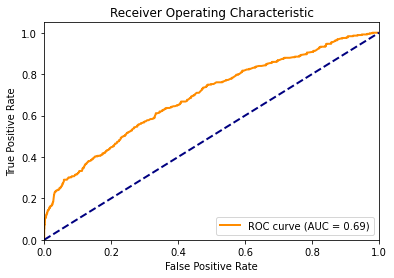

In [1445]:
from sklearn.metrics import roc_curve, auc

# Compute predicted probabilities
proba_predictions = model.predict_proba(X_test)

# Compute ROC curve and AUC
fpr, tpr, thresholds = roc_curve(y_test, proba_predictions[:, 1])
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

In [1447]:
predictions = model.predict(X_test)
tn, fp, fn, tp = metrics.confusion_matrix(y_test, predictions).ravel()

In [1448]:
print(f"True positives: {tp}")
print(f"False positives: {fp}")
print(f"True negatives: {tn}")
print(f"False negatives: {fn}\n")

print(f"Accuracy: {metrics.accuracy_score(y_test, predictions)}")
print(f"Precision: {metrics.precision_score(y_test, predictions)}")
print(f"Recall: {metrics.recall_score(y_test, predictions)}")

True positives: 22
False positives: 2
True negatives: 3295
False negatives: 333

Accuracy: 0.9082694414019715
Precision: 0.9166666666666666
Recall: 0.061971830985915494


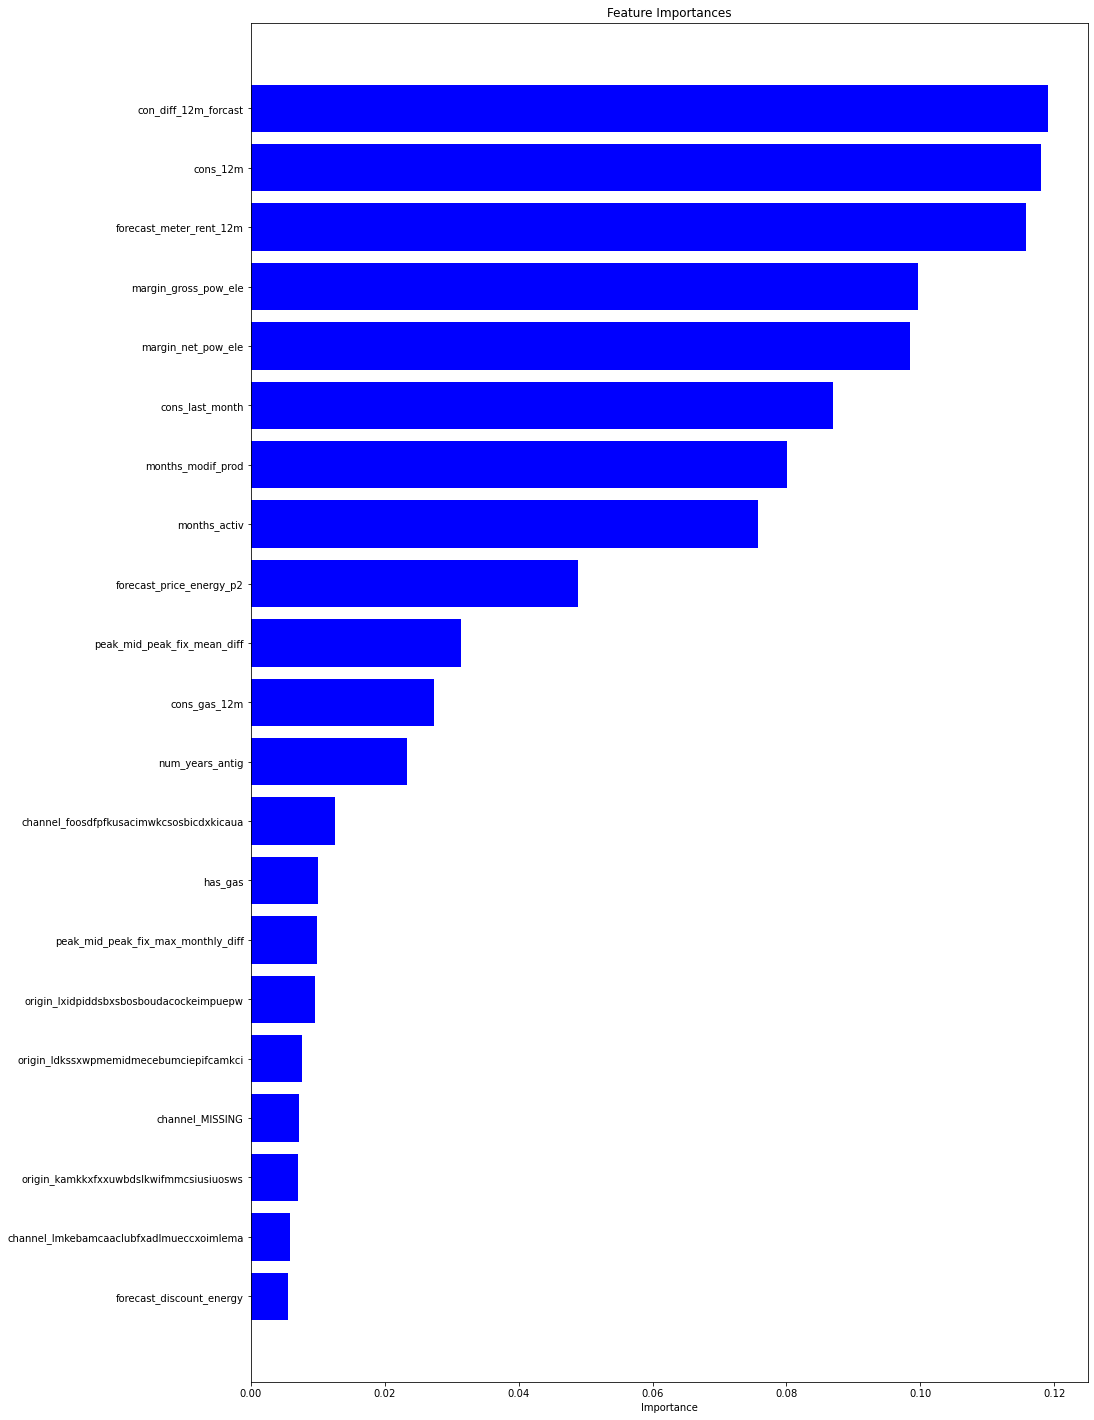

In [1449]:
feature_importances = pd.DataFrame({
    'features': X_train.columns,
    'importance': model.feature_importances_
}).sort_values(by='importance', ascending=True).reset_index()

plt.figure(figsize=(15, 25))
plt.title('Feature Importances')
plt.barh(range(len(feature_importances)), feature_importances['importance'], color='b', align='center')
plt.yticks(range(len(feature_importances)), feature_importances['features'])
plt.xlabel('Importance')
plt.show()

In [1450]:
X_test = X_test.reset_index()
X_test.drop(columns='index', inplace=True)

In [1452]:
X_test['churn'] = predictions.tolist()
X_test['churn_probability'] = probabilities.tolist()
X_test.to_csv('out_of_sample_data_with_predictions.csv')

In [1453]:
pd.read_csv('out_of_sample_data_with_predictions.csv')

,Unnamed: 0,peak_mid_peak_fix_mean_diff,peak_mid_peak_fix_max_monthly_diff,con_diff_12m_forcast,months_activ,months_modif_prod,cons_12m,cons_gas_12m,cons_last_month,forecast_discount_energy,...,margin_net_pow_ele,num_years_antig,channel_MISSING,channel_foosdfpfkusacimwkcsosbicdxkicaua,channel_lmkebamcaaclubfxadlmueccxoimlema,origin_kamkkxfxxuwbdslkwifmmcsiusiuosws,origin_ldkssxwpmemidmecebumciepifcamkci,origin_lxidpiddsbxsbosboudacockeimpuepw,churn,churn_probability
0,0,0.00000,0.00000,0.00263,0.22963,0.00662,0.00232,0.00000,0.00261,0.00000,...,0.08328,0.25000,1,0,0,0,0,1,0,0.14200
1,1,0.28965,0.28965,0.92330,0.27407,0.35099,0.92337,0.00000,1.00000,0.00000,...,0.09233,0.33333,0,0,1,0,0,1,0,0.07300
2,2,0.28849,0.28849,0.01767,0.40000,0.46358,0.01781,0.00000,0.00937,0.00000,...,0.19987,0.41667,0,1,0,1,0,0,0,0.08600
3,3,0.28878,0.28965,0.00589,0.43704,0.49669,0.00542,0.00000,0.00069,0.00000,...,0.04543,0.41667,0,1,0,1,0,0,0,0.02800
4,4,0.28936,0.28965,0.00573,0.83704,0.05960,0.00578,0.00000,0.00418,0.00000,...,0.08331,0.83333,1,0,0,0,1,0,0,0.06300
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3647,3647,1.00000,1.00000,0.00419,0.40000,0.05960,0.00392,0.00000,0.00087,0.00000,...,0.00032,0.41667,0,1,0,1,0,0,0,0.13500
3648,3648,0.28926,0.28965,0.00155,0.56296,0.05298,0.00109,0.00000,0.00063,0.00000,...,0.40845,0.58333,1,0,0,0,0,1,0,0.26900
3649,3649,0.00000,0.00000,0.00136,0.42963,0.49007,0.00093,0.00000,0.00000,0.00000,...,0.02648,0.41667,1,0,0,1,0,0,0,0.37100
3650,3650,0.28849,0.28849,0.00526,0.40000,0.06623,0.00524,0.00000,0.00392,0.00000,...,0.06598,0.41667,0,0,1,1,0,0,0,0.05700
